--- 
### Project for the course in OSE Data Science | Summer 2021, M.Sc. Economics, Bonn University | Emily Schwab

# Replication of Harounan Kazianga, Dan Levy, Leigh L. Linden, and Matt Sloan  (2013) <a class="tocSkip">   
---

My final project for the OSE Data Science course replicates the results published in the following journal article:

> **Kazianga, H., Levy, D., Linden, L. L., & Sloan, M. (2013)**. The Effects of “Girl-Friendly” Schools: Evidence from the BRIGHT School Construction Program in Burkina Faso. *American Economic Journal: Applied Economics*, 5(3), 41-62.

The published article as well as the project's data set and corresponding code can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/app.5.3.41).

##### How to view this notebook:

* To view this notebook, please download the project's [GitHub repository](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-s6emschw). Alternatively, it is possible to use _MyBinder_ or _NBViewer_. In the case that the causal graph images located in section 4 of the notebook do not appear while using these alternative viewing options, they are also available in the repository's [files](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-s6emschw/tree/master/files) folder.


---
# Table of Contents
---
1. [Introduction](#introduction)
2. [The BRIGHT Program](#2)
3. [Regression Discontinuity Design](#3)
4. [A Visual Interpretation of the RD Design through Causal Graphs](#4)
5. [Replication Results](#5)
    * 5.1. [Description of Data Collection Procedure](#5.1)
    * 5.2. [Internal Validity of Research Design](#5.2)
        * 5.2.1. [Measurement of Treatment Differential](#5.2.1)
        * 5.2.2. [Continuity Checks](#5.2.2)
        * 5.2.3. [Measured Differences in Educational Infrastructure](#5.2.3)
    * 5.3. [Estimated Treatment Effects](#5.3)
        * 5.3.1. [Treatment Effect on Enrollment](#5.3.1)
        * 5.3.2. [Treatment Effect on Test Scores](#5.3.2)
    * 5.4. [School Access vs. BRIGHT Amenities](#5.4)
6. [Project Extensions](#6)
    * 6.1. [Supplementary Analysis of the Critical Continuity Assumption](#6.1)
        * 6.1.1 [Initial Analysis of Descriptive Statistics for Control and Treatment Groups](#6.1.1)
        * 6.1.2. [Visual Analysis of the Continuity Assumption](#6.1.2)
    * 6.2. [Treatment Effect on Normalized Math and French Test Scores Disaggregated by Gender](#6.2)
    * 6.3. [Plotting Parametric Regression Results](#6.3)
        * 6.3.1. [Joint and Separate Regression Discontinuity Plots for the Treatment Effect on Attendance](#6.3.1)
        * 6.3.2. [Joint and Separate Regression Discontinuity Plots for the Treatment Effect on Normalized Total Test Scores](#6.3.2)
    * 6.4. [Evaluation of Placebo Thresholds](#6.4)
        * 6.4.1. [Placebo Tests for the Treatment Effect on School Attendance](#6.4.1)
        * 6.4.2. [Placebo Tests for the Treatment Effect on Total Test Scores](#6.4.2)
    * 6.5. [Bandwidth Sensitivity Checks](#6.5)
7. [Concluding Remarks](#7)
8. [Bibliography](#8)


In [22]:
import pandas as pd 
import numpy as np
import numpy as geek

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Probit

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from functools import partial

from stargazer.stargazer import Stargazer, LineLocation
#from IPython.display import Image
from IPython.core.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib as plt

import warnings;
warnings.filterwarnings('ignore');


from auxiliary.aux_plots import *
from auxiliary.aux_predictions import *
from auxiliary.aux_tables import *


---
# 1. Introduction <a name="introduction"></a>
---

In Kazianga et al. (2013), the authors use a regression discontinuity design (RD design) to examine the effects of a "girl-friendly" primary school program implemented by the Ministry of Education in Burkina Faso. Despite an increase in primary school enrollment throughout the world, many regions including sub-Saharan Africa are struggling to catch up. As late as 2010, the net primary school enrollment rate in sub-Saharan Africa was 76 percent, approximately 14 percentage points below the average for emerging countries. 

Additionally, Kazianga et al. (2013) point to several possible reasons, why education outcomes for girls are worse compared to those of their male counterparts. In many regions, long commutes make it difficult for students to travel to and from school. This limitation may be particularly difficult for girls to overcome, if their parents are more apprehensive about allowing them to travel. A lack of basic school infrastructure including gender-segregated bathrooms as well as an insufficient supply of female teaching staff pose further restrictions that negatively impact the primary school enrollment rate among girls. 

While the above issues reflect a potential shortage concerning the economic supply of school facilities, Kazianga et al. (2013) also consider whether the low enrollment rate in regions like sub-Saharan Africa could be a consequence of limited economic demand for educational services - given the relatively minimal returns to educational investments in the region, especially for girls. In addition to evaluating the effects of an education policy program on a number of outcomes including enrollment, test scores, and attendance, Kazianga et al. (2013) contribute insights regarding whether the below average enrollment rate in sub-Saharan Africa is a reflection of low economic supply or of low economic demand. 

Using a scoring procedure to rank villages based on the number of school-aged girls likely to benefit from educational services, the Ministry of Education randomly allocated schools with several girl-friendly amenities and teaching resources to 132 villages. This program, called the  Burkinabé Response to Improve Girls’ Chances to Succeed (BRIGHT) program, was announced in 2005.  Due to the randomness of the program's selection procedure, Kazianga et al. (2013) were able to employ an RD design to examine the causal impact of the BRIGHT program. 

In the following project report, I examine the analysis conducted by Kazianga et al. (2013) and replicate their main findings. Section 2 consists of a brief description of the BRIGHT program and its school allocation procedure. Sections 3 and 4 provide an introduction to the basic properties of the RD design. In section 5, I discuss the results of my replication efforts. Section 6 presents a number of robustness checks that I use to further evaluate the main findings of Kazianga et al. (2013). In section 7, I conclude my analysis.  

---
# 2. The BRIGHT Program <a name="2"></a>
---

In an effort to improve academic outcomes in rural regions of Burkina Faso by 1) increasing access to schools and 2) offering unique amenities to encourage enrollment among girls of primary-school age, the BRIGHT program selected 132 villages to participate in its education policy package. The program provided each village with a three-classroom school, housing for three teachers, gender-segregated bathroom facilities, and a source of clean water. The schools were also equipped with student and teacher desks, chairs, metal bookshelves, two multipurpose halls, and a playground. 

Additionally, the BRIGHT program implemented a series of interventions to incentivize children, parents, and teachers. Schools arranged meals for all students each day they were in attendance. Female students were given supplementary food rations to take home each month provided they maintained an attendance rate of 90 percent. Students also received school supplies and textbooks. The program targeted parents by organizing an information campaign about the advantages of education, with emphasis on the particular benefits for girls. It also offered an adult literacy program for mothers as well as capacity building resources to aid local officials. Furthermore, BRIGHT prioritized the placement of female teachers in its schools and coordinated gender sensitivity trainings for teachers as well as ministry representatives.

The scoring system developed by the Ministry of Education to objectively allocate schools followed a careful procedure, in which 293 villages from 10 provinces and 49 departments (geographically, Burkina Faso is organized into 13 regions, 45 provinces, and 301 departments) were nominated to participate in the BRIGHT program. After each village completed a survey to assess its eligibility as a recipient of a BRIGHT school, the government then scored each village based on the approximate number of children in and around the nominated village, who would likely benefit from the education services offered by the BRIGHT program. Additional weight was also given to primary school-aged girls belonging to the proposed and nearby villages. The villages in each department were then ranked with the top 50 percent of villages receiving a BRIGHT school. Because some villages were later deemed inappropriate locations for the construction of a BRIGHT school (i.e., due to having an insufficient water source), the total number of villages selected for the BRIGHT program and ultimately received a school amounted to 127. Five additional villages that were initially not selected for the BRIGHT program based on their assigned score were later granted a school. Despite this minor discrepancy, the authors' analysis maintains the assumption that the assignment rule was strictly applied. 

---
# 3. Regression Discontinuity Design <a name="3"></a>
---

Using an RD design, Kazianga et al. (2013) examine the observations around an arbitrarily assigned cutoff to identify local treatment effects caused by the BRIGHT program's policy interventions. In the following section, I will explain the general properties of the RD design as well as address how Kazianga et al. (2013) implement this approach in their analysis. 

The RD design is a common quasi-experimental evaluation strategy that relies on an independent cutoff to assign observations into treatment and control groups. In a typical RD design individuals just above the cutoff are selected into treatment, while those just below the cutoff comprise the control group. As long as the cutoff is exogenously chosen such that it is not correlated with other factors that potentially influence the main outcome variable(s), the RD design takes advantage of the cutoff's ability to generate two groups that are as good as randomly selected (Cunningham, 2021). This critical assumption of the RD design, referred to in the literature as **continuity**, implies that the researcher can rule out systematic differences between the control and treatment groups. As a result, any measurable outcome differentials observed at the cutoff can be safely attributed to the treatment (Thistlethwaite and Campbell, 1960).

The potential outcomes framework is an essential concept for further understanding the validity of the RD design. According to the identification strategy's basic setup, there is a treatment variable $T$, which is a discontinuous function of some running variable $X$, 

\begin{equation}
T_{i}=I\left\{X_{i}>c\right\},
\end{equation}

as well as two potential outcomes, $Y_{0}$ and $Y_{1}$. These potential outcomes exist as two unique, continuous functions that describe the underlying relationship between average outcomes and the running variable, which are characterized as $E[Y_i(1)|X]$ and $E[Y_i(0)|X]$. However, the researcher only observes the true outcome, $Y_i$. For all observations, where the running variable $X$ is below the threshold $c$ and subsequently $T = 0$, the researcher can only observe $E[Y_i(0)|X]$. Observations that exist to the right of the cutoff conversely fall into treatment, where the researcher only has access to $E[Y_i(1)|X]$. Hence, the researcher cannot observe both outcomes simultaneously for any individual in the sample.

If we consider the limits of either potential outcome function as the running variable approaches the cutoff from the right and from the left, randomness of the treatment assignment indicates that the limits should be equal:   

\begin{equation}
lim_{\epsilon \downarrow 0}E[Y_i|X_i=c+\epsilon] = lim_{\epsilon \uparrow 0} E[Y_i|X_i=c+\epsilon]
\end{equation}

That is, the potential outcomes behave continuously at the cutoff, thus indicating that the critical assumption of the RD design holds. Under these circumstances, the RD design is a valid identification strategy, and any discontinuity in the outcome variable at the cutoff is interpreted as a consequence of the treatment (Lee and Lemieux, 2010):  

\begin{equation}
lim_{\epsilon \downarrow 0}E[Y_i(1)|X_i=c+\epsilon] - lim_{\epsilon \uparrow 0} E[Y_i(0)|X_i=c+\epsilon] 
\end{equation}

\begin{equation}
= E[Y_i(1)|X=c] - E[Y_i(0)|X=c]
\end{equation}

\begin{equation}
= E[Y_i(1)-Y_i(0)|X=c].
\end{equation}
  
Returning to the application of the RD design in Kazianga et al. (2013), the authors produce an independent running variable called $\text{Rel_Score}_{j}$ based on the survey scores computed for each village. To generate the relative score assigned to each sample village, the authors identified, for each department, the lowest survey score from all villages that were selected to receive a BRIGHT school as well as the highest score from all villages that were not selected. The point of discontinuity for each department was thus determined by computing the halfway point between these two scores. The authors then rescaled the cutoff scores to derive $\text{Rel_Score}_{j}$, equal to the village's assigned score minus the cutoff score calculated for the department to which the village belongs. As mentioned above, the assignment rule places villages with a $\text{Rel_Score}_{j}$ larger than zero into treatment. Villages that do not fulfill this criterium become a part of the control group and consequently do not receive a BRIGHT school. Although some villages were assigned a BRIGHT school despite having a $\text{Rel_Score}_{j}$ less than zero, Kazianga et al. (2013) continue with their analysis as if the assignment rule were strictly carried out and thus apply the following OLS regression to their data set represented here by equation (1): 

\begin{equation}
y_{i h j k}=\beta_{0}+\beta_{1} T_{j}+f\left(\text{Rel_Score}_{j}\right)+\delta \mathbf{X}_{i h j k}+\gamma \mathbf{Z}_{k}+\varepsilon_{i h j k},
\end{equation} 

where $i$ identifies the individual child from household $h$ located in village $j$ and department $k$. The dependent variable $y_{i h j k}$ constitutes several outcomes of interest that the authors explore in their analysis including test scores, enrollment, attendance, etc. $T_{j}$ is a binary variable that indicates whether or not a village was assigned into treatment. The authors also incorporate $f\left(\text{Rel_Score}_{j}\right)$ as a polynomial expansion for the relative score. The variable ${X}_{i h j k}$ includes several child and household characteristics, and ${Z}_{k}$ represents department fixed effects. 

This strategy is comparable to fitting a linear regression below the cutoff and another above it. The intercept of the regression below the cutoff is $\beta_{0}$. In other words, the intercept is equivalent to the expected value at the threshold such that $\beta_{0} = lim_{\epsilon \uparrow 0} E[Y_i|X_i=c+\epsilon]$. Conversely, the intercept of the regression above the threshold, $\beta_{0} + \beta_{1}$, is also the expected value at the threshold as the running variable approaches the cutoff from the right: $lim_{\epsilon \downarrow 0} E[Y_i|X_i=c+\epsilon]$. 

Finally, the following solution is obtained (Cunningham, 2021):  

\begin{equation}
lim_{\epsilon \downarrow 0}E[Y_i(1)|X_i=c+\epsilon] - lim_{\epsilon \uparrow 0} E[Y_i(0)|X_i=c+\epsilon] = \beta_{1} = E[ATE|X=c].
\end{equation}

From this simple linear regression model, the coefficient of interest, $\beta_{1}$, effectively estimates the average treatment effect at the selected cutoff.    


--- 
# 4. A Visual Interpretation of the RD Design through Causal Graphs <a name="4"></a>
---

To further understand how the RD design yields such convincing measures of causal effect in many scenarios, I provide an explanation of its properties with the help of a simple data generating graph derived from Cunningham (2021). According to the basic setup of an RD design, treatment is assigned based on an continuous running variable $X$ ($X \rightarrow T$). Additionally, the running variable may influence the outcome variable directly ($X \rightarrow Y$) as well as indirectly via one or more observable or unobservable variables represented by $U$ ($X \rightarrow U \rightarrow Y$). 

#### Graph 1. Data Generating Graph
<img src = "files/data_gen_graph.png" style = "width:450px"/>

In this case, the running variable thus produces potential endogeneity biases, as it influences both $T$ and $Y$. Since we also face the dilemma that we cannot simultaneously account for a given observation in both the treatment and in the control group, it is infeasible to use a matching method (Cunningham, 2021). 

We can alternatively use an RD design to eliminate the endogeneity bias and more effectively measure the causal effect of the treatment. To do so, the RD design's continuity assumption eliminates the direct effect the running variable imposes on the $Y$ outcome ($X \rightarrow Y$). The strength of the RD design is illustrated in Graph 2, which has removed this direct effect by introducing an independent cutoff value, $c$.

#### Graph 2. RD Design 
<img src = "files/causal_graph_RDD.png" style = "width:450px"/>

Consequently, this identification strategy looks more closely at a subset of observations located just above and just below this threshold in order to simulate random selection of observations into either the treatment or control group. The RD design thus neutralizes any omitted variable bias that may otherwise confound the estimated causal effect (Cunningham, 2021).          

---
# 5. Replication Results <a name="5"></a>
---

## 5.1. Description of Data Collection Procedure <a name="5.1"></a>

After implementing the BRIGHT program in 2005, a survey was conducted in the spring of 2008 that collected information on school and household characteristics for 293 villages. To conduct the household survey, the research team initially collected census data from the participating villages for all households with children between five and 12 years of age. For each village, 30 households with primary school-aged girls were then randomly chosen for the survey. The selection of households was stratified based on each household's access to a beast of burden - a characteristic that served as an appropriate proxy for wealth to generate a representative sample of households in each village. The three strata include the following household types: 

* those that owned at least one beast of burden,
* those that did not own a beast of burden, but had access to one, and
* those that neither owned nor had access to one. 

To ensure randomness, ten households were selected by drawing the names of eligible households out of a hat for each stratum (Levy et al., 2009a).  

The household questionnaire included a series of socio-demographic questions as well as an account of the academic status and background of all children between the ages of five and 12 belonging to each of the surveyed households. The children also completed a test based on math and French language competencies from the government-issued first grade textbook.

The survey on school characteristics included a maximum of three schools for each village. The data collection team spoke with village elders to identify the number of schools, if any, available for regular attendance by the primary school-aged children living in the respective  village. Data collectors then chose the three closest schools within a 10-kilometer radius of each village center, generating a sample of 370 schools in total. The response rate for the school survey was 99.2 percent, with 367 out of the original 370 schools completing the questionnaire.  The survey documented the availability of several amenities including those provided by the BRIGHT program. It also recorded specific characteristics of each school's physical infrastructure, teaching faculty, and student attendance roster (Levy et al., 2009a). 

Due to challenges locating particular villages, the data collection team was unable to survey four of the 293 nominated villages for the household-related part of the survey. Additionally, the authors removed two further villages from the final dataset that were the only ones from their respective departments to have been nominated for a BRIGHT school. For this reason, the research team was unable to compute a relative score for these villages. All children five years of age were also dropped from the final data set due to the fact that primary school attendance in Burkina Faso typically caters to children between the ages of six and 12 years old. After removing the six unavailable villages and all five-year-olds from the original survey report, the final data set included a sample of 287 villages, 8,432 households, and 17,970 children between six and 12 years of age (Levy et al., 2009a).


In [23]:
data = pd.read_stata('data/BRIGHT_Formatted.dta')
data.fillna(np.nan, inplace = True)

In [24]:
data

,Ch_Age,Ch_Girl,Ch_GirlXMCC_School,Ch_GirlXatt,Ch_GirlXhas_school,Ch_GirlXproj,Ch_HeadChild,Ch_HeadGrandChild,Ch_HeadNephew,Ch_Highest_Grade,...,toilets,toilets_gender,total_norm,village_id,village_level,water_supply,words_easy_norm,words_easy_raw,words_hard_norm,words_hard_raw
0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,-0.121444,NaN,0.0,NaN,-0.526749,0.0,-0.439538,0.0
1,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,-0.598520,NaN,0.0,NaN,-0.526749,0.0,-0.439538,0.0
2,9.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,-0.598520,NaN,1.0,NaN,-0.526749,0.0,-0.439538,0.0
3,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,-0.598520,NaN,0.0,NaN,-0.526749,0.0,-0.439538,0.0
4,12.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,-0.280470,NaN,0.0,NaN,-0.526749,0.0,-0.439538,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23277,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,...,NaN,NaN,0.355631,82.0,0.0,NaN,-0.526749,0.0,-0.439538,0.0
23278,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,-0.598520,82.0,0.0,NaN,-0.526749,0.0,-0.439538,0.0
23279,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,-0.598520,82.0,0.0,NaN,-0.526749,0.0,-0.439538,0.0
23280,10.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,...,NaN,NaN,0.196606,82.0,0.0,NaN,-0.526749,0.0,-0.439538,0.0


## 5.2. Internal Validity of Research Design <a name="5.2"></a>

Before Kazianga et al. (2013) present the estimated treatment effects from the BRIGHT program, they first provide a number of internal validity checks to ensure that the RD design serves as an appropriate identification strategy. As the treatment $T$ is a discontinuous function of the design's running variable $X$, section 5.2.1. replicates Figure 1 and Table 1 of Kazianga et al. (2013), in which the authors confirm the existence of a treatment differential at the cutoff. In section 5.2.2., I reproduce the analysis originally conducted by Kazianga et al. (2013) to verify that their data set fulfills the critical continuity assumption of the RD design. Section 5.2.3. replicates the authors' final validity check, where they evaluate whether the discontinuity in assigned treatment generated a notable difference in the educational infrastructure accessible to children from the control and treatment groups.

### 5.2.1. Measurement of Treatment Differential <a name="5.2.1"></a>

#### Figure 1. Probability of Receiving a BRIGHT Program According to Village's Relative Score

Figure 1 from Kazianga et al. (2013) replicated below uses a nonparametric procedure to estimate a village's probably of receiving a BRIGHT school based on its assigned relative score. While the full range of the relative score variable is (-855.5, 3791), the authors limit their analysis to observations with a relative score between -250 and 250. The probability of receiving a BRIGHT school is located on the left vertical axis, and the horizontal axis represents the restricted range of the relative score. The plot, which is represented by the black curves on either side of the cutoff, was generated by a linear local polynomial estimator with an Epanechnikov kernel and a bandwidth of 60 points. As indicated by the visualization, there is a clear discontinuity of assigned treatment at the cutoff. For those villages with a relative score less than zero, the probability of being selected into treatment is more or less zero. There are, however, a few low estimated probabilities due to the few villages in the final data set that were given a BRIGHT school despite not fulfilling the assignment rule. Observing the villages with a relative score to the right of the cutoff, the probability of receiving a BRIGHT school increases to above 80 percent.    

In [25]:
X_untreated = compute_X_axis(0,-250,100)
X_treated = compute_X_axis(250,0,100)

In [26]:
selected_columns_graph_1 = ["selected", "proj_selected", "rel_score_redefined","rel_score", "village_level"]

rslt_untreated_graph_1 = get_data_graphs(selected_columns_graph_1,1,0)
rslt_treated_graph_1 = get_data_graphs(selected_columns_graph_1,1,1)
rslt_graph_1 = get_data_graphs(selected_columns_graph_1,1,2)

In [27]:
y_var_graph_1 = "selected"
x_var_graph_1 = "rel_score_redefined"
bandwidth = 60

control_graph_1 = [compute_locally_weighted_reg(y_var_graph_1,x_var_graph_1,item,bandwidth, rslt_untreated_graph_1) for item in X_untreated]
treatment_graph_1 = [compute_locally_weighted_reg(y_var_graph_1,x_var_graph_1,item,bandwidth, rslt_treated_graph_1) 
                     for item in X_treated]

df_graph_1 = pd.DataFrame()
df_graph_1["y-axis"] = control_graph_1 + treatment_graph_1
df_graph_1["x-axis"] = X_untreated + X_treated

In addition to the nonparametric plot described above, Figure 1 contains orange point estimates that represent the average probabilites for 60-point bins to the left and right of the cutoff. These averages closely reflect the results of the linear local polynomial estimator and further indicate a discontinuity of assigned treatment at the cutoff.

In [7]:
bins_rhs_graph_1 = compute_binned_averages(1,"selected",60,5,rslt_graph_1)
bins_lhs_graph_1 = compute_binned_averages(0,"selected",60,5,rslt_graph_1) 

Following a procedure detailed by Card, Mas, and Rothstein (2008), the authors  plot the $R^2$ values estimated for the specification described here in equation (2): 

\begin{equation}
y_{i h j}=\alpha_{0}+\alpha_{1} I_{\left(\text {Rel_Score}_{j} \geq a\right)}+\varepsilon_{i h j}
\end{equation}

to confirm that the selected cutoff appropriately locates the discontinuity for treatment probability. The plotted $R^2$ values are represented by the blue curve in Figure 1.

In [8]:
R_sq_iterated_df_graph_1 = create_R_sq_df("selected","rel_score_redefined",rslt_graph_1)

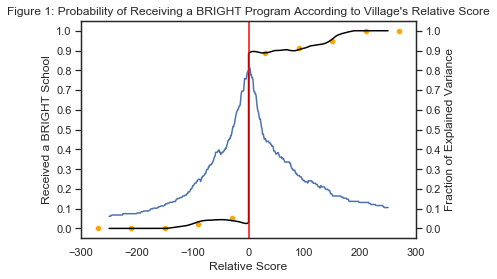

In [9]:
ylabel_graph_1 = "Received a BRIGHT School"
title_graph_1 = "Figure 1: Probability of Receiving a BRIGHT Program According to Village's Relative Score"
plot_discontinuity(ylabel_graph_1, title_graph_1, df_graph_1, bins_lhs_graph_1, bins_rhs_graph_1, 
                   R_sq_iterated_df_graph_1, 1)

As shown below in the dataframe `arg_maximum_graph_1`, the $R^2$ values  achieve a maximum of approximately 0.815 at a relative score of around 1 or 2. This estimate is consistent with assigned treatment varying discontinuously at zero.

In [10]:
arg_maximum_graph_1 = R_sq_iterated_df_graph_1.loc[R_sq_iterated_df_graph_1["R-squared Values"] == max(R_sq_iterated_df_graph_1["R-squared Values"])]
arg_maximum_graph_1

,Xgrid for R-squared Values,R-squared Values
251,1.0,0.814778
252,2.0,0.814778


#### Table 1. Estimated Discontinuity in Probability of a Village Receiving a BRIGHT School

Using the parametric regression specified in equation (1), the results from Table 1 confirm the size of the discontinuity for treatment probability estimated by the nonparametric plot in Figure 1. According to the preferred quadratic model with department-level fixed effects summarized in column (1), villages with a relative score greater than zero were approximately 87.4 percentage points more likely to be assigned a BRIGHT school. Furthermore, the estimate is statistically significant at the one percent level. While the authors prefer implementing a quadratic expansion of the relative score, they report treatment coefficient estimates for several fitted models including 

1. a linear specification, 
2. a cubic polynomial specification, 
3. a quadratic interaction term between the two main regressors (i.e., the treatment indicator variable and the relative score), and 
4. a specification that includes the treatment indicator variable for a subset of villages with a relative score less than 40.

For each regression, the authors also include controls for deparment-level fixed effects.

Despite these variations in model specification, the coefficient estimate for the treatment indicator variable does not change and remains highly statistically significant. The results reported in both Figure 1 and Table 1 thus provide strong evidence that there exists a sufficient discontinuity in assigned treatment at the defined cutoff. 

In [11]:
y_var_table_1 = ["MCC_School"]
X_matrix_table_1 = ["proj_selected", "rel_score", "clustercode"]
y_table_1,X_table_1= get_data(1,0,0, y_var_table_1, X_matrix_table_1)

In [12]:
fitted_poly_models_table1 = fit_poly_models_iterate(y_table_1, X_table_1, 3, 0)

In [13]:
interact1 = "rel_score"
interact2 = "proj_selected"

mod_table1_interaction = calculate_polynomial_interaction(0, y_table_1,X_table_1, interact1, interact2, 2)

In [14]:
mod_table1_reduced = calculate_reduced_range_40(0,y_table_1,X_table_1)

In [15]:
table_1_models = [fitted_poly_models_table1[1],
                  fitted_poly_models_table1[0],
                  fitted_poly_models_table1[2],
                  mod_table1_interaction,
                  mod_table1_reduced]

table_1_covariate_list = ["proj_selected","rel_score1","rel_score2","rel_score3","interaction_term1",
                          "interaction_term2","const"]

table_1_title = 'Table 1—Estimated Discontinuity in Probability of a Village Receiving a BRIGHT School'

table_1_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)',
                           'rel_score1':'Rel. Score',
                           'rel_score2':'Rel. Score ^ 2',
                           'rel_score3':'Rel. Score ^ 3',
                           'interaction_term1':'Rel. Score x Selected',
                           'interaction_term2':'Rel. Score ^ 2 x Selected',
                           'const': 'Constant'}

table_1_notes = ["Model (1): Quadratic","Model (2): Linear","Model (3): Cubic",
                 "Model (4): Interacted Quadratic","Model (5): |Rel.Score| < 40"]

table_1 = create_table(table_1_models,table_1_covariate_list,table_1_title,table_1_rename_covariates,table_1_notes)
table_1

---

<span style="color:darkred">**NOTE**:</span> For Table 1, I do not replicate the results from the probit quadratic model published by Kazianga et al. (2013) due to complications that I was unable to resolve. However, I do not consider this to be a major drawback, as I successfully replicated all other specification models from the original paper, which sufficiently confirm the robustness of the authors' preferred quadratic model reported in column (1).

---

### 5.2.2. Continuity Checks <a name="5.2.2"></a>

#### Figure 2. Distribution of Sample by Relative Score 

In order to simulate randomness of treatment assignment, a valid RD design requires all other characteristics among the sampled villages to demonstrate continuity at the designated treatment cutoff. As recommended by McCrary (2008), Kazianga et al. (2013) visualize the distribution of children based on the relative scores of their villages. As in Figure 1, the range of relative scores is restricted to (-250, 250).  Although I do not directly follow the complementary Stata code, I construct a histogram using the recommended bin size of 41.2 and include a corresponding density plot to ensure a continuous distribution at the cutoff value. 

With this very basic visual test, it is possible to ensure whether or not villages were able to manipulate their assigned relative score in order to be selected into the treatment group. Figure 2 shows a smooth, uninterrupted density and underlying histograph plot, which suggests that participating villages were successfully assigned to the control and treatment groups at random. In the event that villages could manipulate their assigned relative score, however, the distribution plot would indicate a visible discontinuity, in which the density just above the cutoff would be significantly larger. For example, if villages had been aware of the scoring procedure beforehand, and some had provided false information to data collectors to guarantee receipt of a BRIGHT school, then the treatment group could potentially exhibit characteristics that render it systematically different from the control group. Perhaps villages that provide false information contain a populace that is already aware of the potential benefits of education and therefore willing to manipulate the scoring procedure in order to obtain a BRIGHT school. In this case, later regression estimates that measure the treatment effects of the BRIGHT program could exhibit an upward bias.  

In [16]:
rslt_graph_2 = rslt_graph_1.loc[abs(rslt_graph_1["rel_score_redefined"]) <= 250]

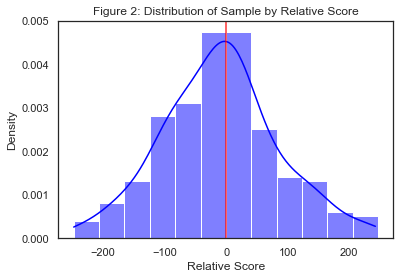

In [17]:
title_graph_2 = 'Figure 2: Distribution of Sample by Relative Score'
xlabel_graph_2 = 'Relative Score'
ylabel_graph_2 = 'Density'
plot_graph_2(ylabel_graph_2, xlabel_graph_2, title_graph_2, rslt_graph_2)

#### Table 2. Continuity of Child Characteristics

As a second continuity check to make sure there are no systematic differences between the control and treatment groups, Kazianga et al. (2013) evaluate several demographic characteristics of the children observed in the study. The first ten outcome variables listed below in Table 2 include child and household characteristics such as the age of the household head, the gender of the household head, the number of household members, the child's age, the gender of the child, and the child's relationship to the head of the household. The following nine outcome variables describe the child's religious, ethnic, and linguist background. The remaining variables provide information on the owned assets of the child's household. 

To estimate the discontinuities around the cutoff for the observed characteristics, Kazianga et al. (2013) regress each of the demographic variables on their preferred quadratic model with department fixed effects. Out of the 28 estimated discontinuities, only three yield regression coefficients that are statistically significant at conventional levels. Economically, the estimated coefficient for assigned treatment is small in all 28 regressions. In fact, the magnitudes of the three statistically significant discontinuities are so small that Kazianga et al. (2013) report implied biases of negligible size. As such, the results in Table 2 confirm that the critical continuity assumption holds for all demographic characteristics observed by the authors. Although discontinuities may exist for unobservable characteristics, the outcomes reported by Kazianga et al. (2013) do not suggest any systematic differences between the control and treatment groups that may bias the treatment effect estimates. 

In [18]:
y_var_table_2 = ["Hh_HeadMale", "Hh_HeadAge", "Hh_HeadSchool", "Hh_NumMembers", "Hh_NumKids", "Ch_Age",
                "Ch_Girl","Ch_HeadChild", "Ch_HeadGrandChild", "Ch_HeadNephew","Hh_ReligionMuslin", "Hh_Animist",
                "Hh_Christian", "Hh_Lang_Fulfude", "Hh_Lang_Gulmachema","Hh_Lang_Moore", "Hh_Ethnicity_Gourmanche", 
                "Hh_Ethnicity_Mossi", "Hh_Ethnicity_Peul", "Hh_FloorBasic", "Hh_RoofBasic", "Hh_Radio", "Hh_Telmob",
                "Hh_Watch", "Hh_Bike", "Hh_Cows","Hh_Motorbike", "Hh_Cart"]

X_matrix_table_2 = ["proj_selected", "rel_score", "clustercode"]

y_table_2,X_table_2 = get_data(0,0,0, y_var_table_2, X_matrix_table_2)


In [19]:
table_2 = create_table_df(y_table_2, y_var_table_2, X_table_2, 1,1)
table_2

,Regression Coefficient at Cutoff,Standard Error,P-value,Sample Average
Outcome Variables,,,,
Hh_HeadMale,-0.008,0.006,0.158,0.982
Hh_HeadAge,-0.652,0.554,0.239,48.058
Hh_HeadSchool,-0.013,0.038,0.738,0.159
Hh_NumMembers,-0.106,0.319,0.740,10.908
Hh_NumKids,0.123,0.180,0.493,6.010
Ch_Age,-0.009,0.044,0.830,8.765
Ch_Girl,0.023,0.010,0.016,0.466
Ch_HeadChild,-0.011,0.012,0.337,0.884
Ch_HeadGrandChild,-0.013,0.008,0.109,0.052


### 5.2.3. Measured Differences in Educational Infrastructure <a name="5.2.3"></a>

#### Table 3. Existence of Any School Type in Villages Sampled

In the third and final validity check of the RD design, Kazianga et al. (2013) determine whether the discontinuity observed in assigned treatment created a notable discontinuity in the educational infrastructure accessible to primary school-aged children. The results in Table 3 report a series of regression coefficients from the preferred quadratic model that estimate the effect of the BRIGHT program on the likelihood that a village has any school, including ones not affiliated with the BRIGHT program. Column (1) estimates, for example, that villages assigned to the treatment group were 32 percentage points more likely to have any school in 2008. 

Columns (2) through (6) measure the effect of the BRIGHT program on the probability that a village has any school in the years leading up to and following the start of the BRIGHT initiative in 2005. As indicated by the coefficient estimates in columns (2) and (3), there is no difference of economic or statistical significance between selected and nonselected village for 2003 and 2004 before the BRIGHT program went into effect. When the BRIGHT program began in 2005, villages selected for a BRIGHT school constructed interim schools in anticipation of receiving a BRIGHT school at a future date. As such, it is apparent in column (4) that the treatment villages were 32.4 percentage points more likely to have a school than the villages in the control group. In 2006, the likelihood increased to 54.8 percentage points when the construction of BRIGHT schools was underway. A year later in 2007, this differential sank to 42 percentage points. Kazianga et al. (2013) further point out that this large and statistically significant difference for the period between 2005 and 2008 took place despite an increase in the number of schools constructed in nonselected villages. The final column in Table 3 suggests that villages in the treatment group had a school approximately 1.6 years earlier compared to villages not chosen to receive a BRIGHT school. 

In [20]:
y_var_table_3_pt1 = ["has_school"]
X_matrix_table_3_pt1 = ["proj_selected", "rel_score", "clustercode"]

y_table_3_pt1,X_table_3_pt1 = get_data(1,0,0, y_var_table_3_pt1, X_matrix_table_3_pt1)

y_var_table_3_pt2 = ["Vill_HadSchool2003","Vill_HadSchool2004","Vill_HadSchool2005","Vill_HadSchool2006",
                     "Vill_HadSchool2007", "Vill_YearsOfSchool"]

X_matrix_table_3_pt2 = ["proj_selected", "rel_score", "clustercode",]

y_table_3_pt2,X_table_3_pt2 = get_data(1,1,0, y_var_table_3_pt2, X_matrix_table_3_pt2)


In [21]:
mod_table3_rel_2 = calculate_polynomial_features(0,y_table_3_pt1,X_table_3_pt1,2)
varying_depend_var_table3 = regress_for_diff_outcomes_poly_features(y_table_3_pt2,y_var_table_3_pt2,X_table_3_pt2,2,0)

In [22]:
##Compute non-selected averages 
non_sel_average1 = y_table_3_pt1.loc[X_table_3_pt1["proj_selected"] == 0].mean().values.tolist()
non_sel_average2 = y_table_3_pt2.loc[X_table_3_pt2["proj_selected"] == 0].mean().values.tolist()
non_sel_averages = non_sel_average1 + non_sel_average2
non_sel_averages_rnded = [round(num, 3) for num in non_sel_averages]

In [23]:
table_3_models = [mod_table3_rel_2,
                  varying_depend_var_table3[0],
                  varying_depend_var_table3[1],
                  varying_depend_var_table3[2],
                  varying_depend_var_table3[3],
                  varying_depend_var_table3[4],
                  varying_depend_var_table3[5]]

table_3_covariate_list = ["proj_selected","rel_score1","rel_score2", "const"]

table_3_title = 'Table 3—Existence of Any School Type in Villages Sampled'

table_3_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)','rel_score1':'Rel. Score',
                             'rel_score2':'Rel. Score ^ 2','const': 'Constant'}
table_3_notes = ['']

table_3 = create_table(table_3_models,table_3_covariate_list,table_3_title,table_3_rename_covariates,table_3_notes)

table_3.custom_columns(['Any School, 2008', 'Village Had School, 2003','Village Had School, 2004',
                       'Village Had School, 2005', 'Village Had School, 2006', 'Village Had School, 2007',
                        'Number of Years with School'], [1, 1, 1, 1, 1, 1, 1])

table_3.add_line('Nonselected average', non_sel_averages_rnded,LineLocation.FOOTER_TOP)
table_3

#### Table 4. Comparison of Schools Attended by Students from Selected and Nonselected Villages

In addition to measuring the effect of the BRIGHT program on accessibility to education services in treatment villages, Kazianga et al. (2013) compare several characteristics of traditional and BRIGHT schools along the following three categories: 

1. girl-friendly characteristics (the first five variables reported in Table 4), 
2. school resources (variables six through 11), and 
3. teacher characteristics (the remaining variables in Table 4).

The results reported in Table 4 show that not only did the BRIGHT program increase a child's probability of having access to a school, it also provided specific amenities that schools in nonselected villages lacked. Columns (1) and (2) show that schools in villages from the control group have less access to girl-friendly characteristics such as meal and dry rations programs, gender-segregated bathrooms, or daycare programs (referred to as bisongo in Table 4). They also have fewer school resources (in particular, resources of higher quality) and teachers with experience in terms of postsecondary and gender sensitivity training. In columns (3) to (5), Kazianga et al. (2013) report regression discontinuity results for each of the listed school characteristics and find comparable differentials between selected and nonselected villages.    

In [24]:
y_var_table_4 = ["feeding_program", "dry_rations", "toilets", "toilets_gender", "bisongo", "insufficient_books",
                 "insufficient_desks", "water_supply", "num_rooms_usable", "num_rooms_boards", "num_rooms_rboards",
                 "num_teachers", "num_teachers_female", "num_teachers_postsec", "num_teachers_l5", "num_teachers_l10",
                 "num_teachers_g10", "num_teachers_training"]

X_matrix_table_4 = ["proj_selected", "rel_score", "clustercode"]

y_table_4,X_table_4 = get_data(2,0,0, y_var_table_4, X_matrix_table_4)

In [25]:
table_4 = create_table_df(y_table_4,y_var_table_4,X_table_4, 2, 0)
table_4

,Sample Average for Non-Selected Villages,Sample Average for Selected Villages,Regression Coefficient at Cutoff,Standard Error,P-value
Outcome Variables,,,,,
feeding_program,0.503,0.746,0.247,0.063,0.000
dry_rations,0.105,0.371,0.215,0.051,0.000
toilets,0.327,0.721,0.396,0.063,0.000
toilets_gender,0.240,0.619,0.351,0.063,0.000
bisongo,0.006,0.066,0.046,0.025,0.068
insufficient_books,0.737,0.584,-0.182,0.062,0.004
insufficient_desks,0.357,0.188,-0.250,0.060,0.000
water_supply,0.263,0.614,0.356,0.064,0.000
num_rooms_usable,2.509,3.063,0.508,0.179,0.005


## 5.3. Estimated Treatment Effects <a name="5.3"></a>

After providing evidence to confirm the validity of an RD design, the authors examine the estimated treatment effects of the BRIGHT program. In the main body of their paper, Kazianga et al. (2013) report measured effects on enrollment and test scores. They also discuss treatment differentials according to gender.      

### 5.3.1. Treatment Effect on Enrollment <a name="5.3.1"></a>

#### Table 5. Effects of BRIGHT Schools on Enrollment

According to Table 5, the authors' preferred quadratic regression model (column 1) estimates that the BRIGHT program increased a child's probability of being enrolled in school by 18.5 percentage points. Removing the demographic controls from the preferred model (column 2) provides comparable results, which lends further evidence to the critical assumption that villages assigned relative scores above and below the arbitrary cutoff are **not** systematically different from one another. The coefficient estimates in columns (3) through (6) remain consistent, suggesting robustness of the estimated treatment effect. Using verified enrollment instead of self-reported enrollment as the dependent variable for the results in column (7), the authors estimate a similar albeit slightly smaller coefficient for the treatment indicator variable. As they were only able to visit each school once to directly confirm the presence of each child, who claimed to be enrolled, Kazianga et al. (2013) caution that the beta coefficient in column (7) is likely an underestimate of the treatment effect due to student absences on the day of enrollment verification.        

In [26]:
y_var_table_5 = ["attending","attending2"]
X_matrix_table_5 = ["proj_selected", "rel_score","clustercode"]

y_table_5,X_table_5_controls = get_data(0,0,1, y_var_table_5, X_matrix_table_5)
y_table_5,X_table_5_no_controls = get_data(0,0,0, y_var_table_5, X_matrix_table_5)

In [27]:
fitted_poly_models_table5 = []
for x in range(1, 4): # [1, 2, 3]
    models = calculate_polynomial_features(1,y_table_5.iloc[:,0],X_table_5_controls, x)
    fitted_poly_models_table5.append(models)

In [28]:
fitted_poly_models_table5 = fit_poly_models_iterate(y_table_5.iloc[:,0], X_table_5_controls, 3, 1)

In [29]:
#quadratic model without controls 
mod_table5_rel_2_no_controls = calculate_polynomial_features(1,y_table_5.iloc[:,0],X_table_5_no_controls, 2)

mod_table5_interaction = calculate_polynomial_interaction(1,y_table_5.iloc[:,0],X_table_5_controls,interact1,interact2,2)

mod_table5_reduced = calculate_reduced_range_40(1, y_table_5.iloc[:,0],X_table_5_no_controls)

mod_table5_verified_enroll = calculate_polynomial_features(1,y_table_5.iloc[:,1],X_table_5_controls, 2)

In [30]:
table_5_models = [fitted_poly_models_table5[1],
                  mod_table5_rel_2_no_controls,  
                  fitted_poly_models_table5[0],
                  fitted_poly_models_table5[2],
                  mod_table5_interaction,
                  mod_table5_reduced,
                  mod_table5_verified_enroll
                 ]
table_5_covariate_list = ["proj_selected","rel_score1","rel_score2","rel_score3", "interaction_term1","interaction_term2","const"]

table_5_title = 'Table 5—Effects of BRIGHT Schools on Enrollment'

table_5_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)',
                           'rel_score1':'Rel. Score',
                           'rel_score2':'Rel. Score ^ 2',
                           'interaction_term1':'Rel. Score x Selected',
                           'interaction_term2':'Rel. Score ^ 2 x Selected',
                           'const': 'Constant'}
table_5_notes = ["Model (1): Quadratic", 
                 "Model (2): Quadratic without Controls",
                 "Model (3): Linear",
                 "Model (4): Cubic",
                 "Model (5): Interacted Quadratic",
                 "Model (6): |Rel.Score| < 40", 
                 "Model (7): Quadratic"]

table_5 = create_table(table_5_models,table_5_covariate_list,table_5_title, table_5_rename_covariates,table_5_notes)

table_5.custom_columns(['Reported Enrollment', 'Reported Enrollment', 'Reported Enrollment',
                        'Reported Enrollment','Reported Enrollment','Reported Enrollment',
                        'Verified Enrollment'], [1, 1, 1, 1, 1, 1, 1])
table_5.add_line('Demographic Controls', ['Yes','No','Yes','Yes','Yes','No','Yes'])
table_5.add_line('Department Fixed Effects', ['Yes','Yes','Yes','Yes','Yes','Yes','Yes'])
table_5

---

<span style="color:darkred">**NOTE**:</span> For Table 5, I do not replicate the results from the probit quadratic model published by Kazianga et al. (2013) due to complications that I was unable to resolve. However, I do not consider this to be a major drawback, as I successfully replicated all other specification models from the original paper, which sufficiently confirm the robustness of the authors' preferred quadratic model reported in column (1).

---

#### Figure 3. Probability of Enrollment in School According to Village's Relative Score 

Similar to Figure 1, Kazianga et al. (2013) present the results of a nonparametric estimate for the enrollment treatment effect in Figure 3. The plot measures the probability of school enrollment for primary school-aged children living in selected versus nonselected villages. As indicated by the visualization, there is a clear discontinuity at the cutoff that corroborates the parametric estimates summarized in Table 5. For villages that received a BRIGHT school and had a relative score just above zero, the probability of enrollment is approximately 20 percentage points higher compared to nonselected villages with a relative score just below zero.

The authors also plot the $R^2$ values estimated for the specification described in equation (2) to confirm the location of the discontinuity for enrollment probability. The plotted $R^2$ values are represented by the blue curve in Figure 3. According to the `arg_maximum_graph_3` dataframe produced below, the $R^2$ values are maximized at a relative score of 8, which is sufficiently close to the cutoff value.

In [31]:
selected_columns_graph_3 = ["attending", "proj_selected", "rel_score_redefined","rel_score"]

rslt_untreated_graph_3 = get_data_graphs(selected_columns_graph_3,0,0)
rslt_treated_graph_3 = get_data_graphs(selected_columns_graph_3,0,1)
rslt_graph_3 = get_data_graphs(selected_columns_graph_3,0,2)

In [32]:
y_var_graph_3 = "attending"
x_var_graph_3 = "rel_score_redefined"

In [33]:
control_graph_3 = [compute_locally_weighted_reg(y_var_graph_3,x_var_graph_3,item,bandwidth, rslt_untreated_graph_3) 
                   for item in X_untreated]
treatment_graph_3 = [compute_locally_weighted_reg(y_var_graph_3,x_var_graph_3,item,bandwidth, rslt_treated_graph_3) 
                     for item in X_treated]

df_graph_3 = pd.DataFrame()
df_graph_3["y-axis"] = control_graph_3 + treatment_graph_3
df_graph_3["x-axis"] = X_untreated + X_treated

In [34]:
bins_rhs_graph_3 = compute_binned_averages(1,"attending",60,5,rslt_graph_3)
bins_lhs_graph_3 = compute_binned_averages(0,"attending",60,5,rslt_graph_3)

In [35]:
R_sq_iterated_df_graph_3 = create_R_sq_df("attending","rel_score_redefined",rslt_graph_3)

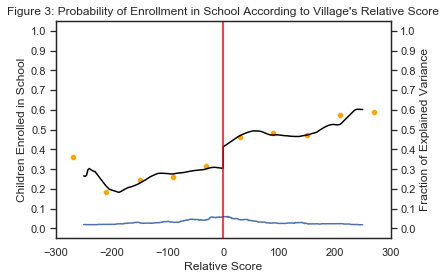

In [36]:
ylabel_graph_3 = "Children Enrolled in School"
title_graph_3 = "Figure 3: Probability of Enrollment in School According to Village's Relative Score"
plot_discontinuity(ylabel_graph_3,title_graph_3,df_graph_3,bins_lhs_graph_3,bins_rhs_graph_3,R_sq_iterated_df_graph_3,1)

In [37]:
arg_maximum_graph_3 = R_sq_iterated_df_graph_3.loc[R_sq_iterated_df_graph_3["R-squared Values"] == max(R_sq_iterated_df_graph_3["R-squared Values"])]
arg_maximum_graph_3

,Xgrid for R-squared Values,R-squared Values
258,8.0,0.060633


#### Table 6. Effects of BRIGHT Schools According to Gender 

As a primary goal of the BRIGHT program was to improve school outcomes for girls, Table 6 disaggregates a number of estimated treatment effects by gender. Using self-reported enrollment (column 1) as the dependent variable, the estimated coefficient for the interaction term between treatment and female indicator variables suggests that the BRIGHT program encouraged girls to attend school at a rate 4.7 percentage points higher than the rate calculated for boys. The estimated effect on verified enrollment (column 2) is comparably large at a rate of 5.6 percentage points over the boys' rate. Although the authors find an economically and statistically significant increase in school enrollment for girls, their results do not identify a significant gender differential in the highest grade achieved (column 3) or in total test scores (column 4).  

In [38]:
y_var_table_6_pt1 = ["attending","attending2", "total_norm"]
y_var_table_6_pt2 = "Ch_Highest_Grade"
X_matrix_table_6 = ["proj_selected", "rel_score", "Ch_GirlXproj", "clustercode"]

y_table_6_pt1,X_table_6_pt1 = get_data(0,0,1, y_var_table_6_pt1, X_matrix_table_6)

y_table_6_pt2, X_table_6_pt1 = get_data(0,0,1, y_var_table_6_pt2, X_matrix_table_6)

In [39]:
varying_depend_var_table6 = regress_for_diff_outcomes_poly_features(y_table_6_pt1,y_var_table_6_pt1,X_table_6_pt1,2,1)

In [40]:
mod_table6_rel_2_cluster = regress_cluster_se_corrected(y_table_6_pt2, X_table_6_pt1, 2)

In [41]:
table_6_models = [varying_depend_var_table6[0], 
                  varying_depend_var_table6[1], 
                  mod_table6_rel_2_cluster,
                  varying_depend_var_table6[2]]

table_6_covariate_list = ["proj_selected","Ch_GirlXproj","rel_score1","rel_score2","const"]

table_6_title = 'Table 6—Effects of BRIGHT Schools According to Gender'

table_6_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)',
                             'Ch_GirlXproj':'Selected x Female',
                             'rel_score1':'Rel. Score',
                             'rel_score2':'Rel. Score ^ 2',
                             'const': 'Constant'}
table_6_notes = [""]

table_6 = create_table(table_6_models,table_6_covariate_list,table_6_title,
                       table_6_rename_covariates,table_6_notes)

table_6.add_line('Demographic Controls', ['Yes','Yes','Yes','Yes'])
table_6.add_line('Department Fixed Effects', ['Yes','Yes','Yes','Yes'])
table_6.custom_columns(['Reported Enrollment','Verified Enrollment','Highest Grade', 'Total Score'], [1,1,1,1])
table_6

### 5.3.2. Treatment Effect on Test Scores <a name="5.3.2"></a>

#### Table 7. Effects of BRIGHT Schools on Total Scores

Further investigation of the program's effect on children's academic outcomes estimates an increase in total test scores by approximately 0.41 standard deviations (Table 7, column 1) using the preferred quadratic model specification. This estimated effect also proves insensitive to variations in the regression model. Although the authors report that the model restricting the relative score to a range of (-40,40) includes demographic controls as well as department fixed effects, the coefficient estimate I computed through my replication efforts did not match the treatment effect disclosed in Table 7 (column 6) of Kazianga et al. (2013). 

Upon further observation, the complementary Stata code suggests that the authors failed to account for demographic controls and only included department fixed effects in the regression model. For the sake of completeness, my replication of Table 7 summarizes the results for both model specifications: the model summarized in column 6 only includes department fixed effects, whereas the specification reported in column 7 accounts for both department-level fixed effects and for demographic controls. Despite this discrepancy in reported outcomes, both models estimate cofficients for the treatment indicator variable that are comparable in size and are statistically significant.   

In [42]:
y_var_table_7 = "total_norm"
X_matrix_table_7 = ["rel_score", "clustercode","proj_selected"]

y_table_7_pt1,X_table_7_pt1 = get_data(0,0,1, y_var_table_7, X_matrix_table_7)

y_table_7_pt2_no_controls,X_table_7_pt2_no_controls = get_data(0,0,0, y_var_table_7,X_matrix_table_7)

In [43]:
fitted_poly_models_table7 = fit_poly_models_iterate(y_table_7_pt1, X_table_7_pt1,3, 1)

mod_table7_rel_2_no_controls = calculate_polynomial_features(1, y_table_7_pt2_no_controls,X_table_7_pt2_no_controls, 2)

mod_table7_interaction = calculate_polynomial_interaction(1, y_table_7_pt1,X_table_7_pt1, interact1, interact2, 2)

#results slightly off, but not way off. Realized why: even though it says controls are included in this regression, 
#they are not included in Stata code. Report both below. 

mod_table7_reduced_no_controls = calculate_reduced_range_40(1, y_table_7_pt1,X_table_7_pt2_no_controls)
mod_table7_reduced = calculate_reduced_range_40(1, y_table_7_pt1,X_table_7_pt1)

In [44]:
table_7_models = [fitted_poly_models_table7[1],
                  mod_table7_rel_2_no_controls,  
                  fitted_poly_models_table7[0],
                  fitted_poly_models_table7[2],
                  mod_table7_interaction,
                  mod_table7_reduced_no_controls,
                  mod_table7_reduced]
table_7_covariate_list = ["proj_selected","rel_score1","rel_score2","rel_score3",
                          "interaction_term1","interaction_term2","const"]
table_7_title = 'Table 7—Effects of BRIGHT Schools on Total Scores'
table_7_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)',
                           'rel_score1':'Rel. Score',
                           'rel_score2':'Rel. Score ^ 2',
                           'interaction_term1':'Rel. Score x Selected',
                           'interaction_term2':'Rel. Score ^ 2 x Selected',
                           'const': 'Constant'}
table_7_notes = ["Model (1): Quadratic", 
                 "Model (2): Quadratic without Controls",
                 "Model (3): Linear",
                 "Model (4): Cubic",
                 "Model (5): Interacted Quadratic",
                 "Model (6): |Rel.Score| < 40 without controls",
                 "Model (7): |Rel.Score| < 40 with controls"]
table_7 = create_table(table_7_models,table_7_covariate_list,table_7_title,
                       table_7_rename_covariates,table_7_notes)
table_7.add_line('Demographic Controls', ['Yes','No','Yes','Yes','Yes','No', 'Yes'])
table_7.add_line('Department Fixed Effects', ['Yes','Yes','Yes','Yes','Yes','Yes', 'Yes'])
table_7

#### Figure 4. Normalized Total Test Score According to Village's Relative Score

Figure 4 employs a similar nonparametric estimation procedure shown in Figures 1 and 3 to complement the parametric results summarized above in Table 7. The discontinuity at the arbitrary cutoff represents a visible increase in total test scores for children, who attended a BRIGHT school.

The authors also plot the $R^2$ values estimated for the specification described in equation (2) to confirm the location of the discontinuity for total test scores. The plotted $R^2$ values are represented by the blue curve in Figure 4. According to the `arg_maximum_graph_4` dataframe produced below, the $R^2$ values are maximized exactly at the zero cutoff. 

In [45]:
selected_columns_graph_4 = ["total_norm", "proj_selected", "rel_score_redefined","rel_score"]

rslt_untreated_graph_4 = get_data_graphs(selected_columns_graph_4,0,0)
rslt_treated_graph_4 = get_data_graphs(selected_columns_graph_4,0,1)
rslt_graph_4 = get_data_graphs(selected_columns_graph_4,0,2)

In [46]:
y_var_graph_4 = "total_norm"
x_var_graph_4 = "rel_score_redefined"

In [47]:
control_graph_4 = [compute_locally_weighted_reg(y_var_graph_4,x_var_graph_4,item,bandwidth, rslt_untreated_graph_4) 
                   for item in X_untreated]
treatment_graph_4 = [compute_locally_weighted_reg(y_var_graph_4,x_var_graph_4,item,bandwidth, rslt_treated_graph_4) 
                     for item in X_treated]

df_graph_4 = pd.DataFrame()
df_graph_4["y-axis"] = control_graph_4 + treatment_graph_4
df_graph_4["x-axis"] = X_untreated + X_treated

In [48]:
bins_rhs_graph_4 = compute_binned_averages(1,"total_norm",60,5,rslt_graph_4)
bins_lhs_graph_4 = compute_binned_averages(0,"total_norm",60,5,rslt_graph_4)

In [49]:
R_sq_iterated_df_graph_4 = create_R_sq_df("total_norm","rel_score_redefined",rslt_graph_4)

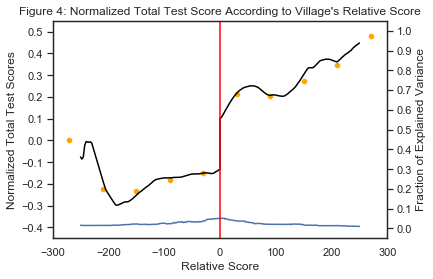

In [50]:
ylabel_graph_4 = "Normalized Total Test Scores"
title_graph_4 = "Figure 4: Normalized Total Test Score According to Village's Relative Score"
plot_discontinuity(ylabel_graph_4, title_graph_4,df_graph_4,bins_lhs_graph_4,bins_rhs_graph_4,
                   R_sq_iterated_df_graph_4,2)

In [51]:
arg_maximum_graph_4 = R_sq_iterated_df_graph_4.loc[R_sq_iterated_df_graph_4["R-squared Values"] == max(R_sq_iterated_df_graph_4["R-squared Values"])]
arg_maximum_graph_4

,Xgrid for R-squared Values,R-squared Values
250,0.0,0.051859


## 5.4. School Access vs. BRIGHT Amenities <a name="5.4"></a>

In the final stage of their analysis, Kazianga et al. (2013) present evidence that examines whether the measured treatment effects were a result of increased school accessibility or of the BRIGHT program's unique characteristics. To do so, the authors make use of two different regression strategies. Using a traditional OLS regression model, they first estimate student outcomes for children in villages with BRIGHT schools, non-BRIGHT schools, and no schools. 

Despite providing evidence to corroborate the critical continuity assumption, Kazianga et al. (2013) address the potential existence of endogeneity bias in their second strategy by restricting the sample of villages to those that had schools in 2004 - just a year before the program announced the villages that were selected to receive a BRIGHT school. Since these schools were upgraded to meet the requirements of a BRIGHT school, the authors took advantage of this knowledge and directly employed the properties of the RD design to estimate the effect of the unique BRIGHT characteristics on student outcomes. For the sake of readability, I have decomposed the original Table 8 in Kazianga et al. (2013) into two smaller tables: Table 8.a. presents the relative effect of the BRIGHT program on enrollment, whereas Table 8.b. summarizes the program's relative effect on total test scores.   

#### Table 8. Relative Effect of School Improvement versus School Access

In [52]:
y_var_table_8 = ["attending", "total_norm"]
X_matrix_table_8 = ["MCC_School", "has_school", "clustercode", "rel_score"]

y_table_8_no_controls,X_table_8_no_controls = get_data(0,0,0, y_var_table_8,X_matrix_table_8)

y_table_8_controls,X_table_8_controls = get_data(0,0,1, y_var_table_8, X_matrix_table_8)

X_matrix_table_8_subset = ["proj_selected","rel_score","Vill_HadSchool2004", "clustercode"]

y_table_8_subset, X_table_8_subset = get_data(0,0,1, y_var_table_8, X_matrix_table_8_subset)

y_table_8_subset = y_table_8_subset.loc[X_table_8_subset["Vill_HadSchool2004"]==1].reset_index(drop = True)
X_table_8_subset = X_table_8_subset.loc[X_table_8_subset["Vill_HadSchool2004"]==1].reset_index(drop = True)

In [53]:
#For some reason, Table 8 reports results for first and fourth columns when fixed effects are NOT included even though 
#the table indicates that fixed effects were included. I report here results for when fixed effects are included, since
#it is more robust to include fixed effects 

varying_depend_var_table8_no_controls = regress_for_diff_outcomes_poly_features(y_table_8_no_controls,
                                                                                y_var_table_8,
                                                                                X_table_8_no_controls,0,1)

#results reported in Table 8, where fixed effects are not included are reported here: 

varying_depend_var_table8_no_controls_or_FEs = regress_for_diff_outcomes_poly_features(y_table_8_no_controls,
                                                                                       y_var_table_8,X_table_8_no_controls.iloc[:,0:5],0,1)

varying_depend_var_table8 = regress_for_diff_outcomes_poly_features(y_table_8_controls,
                                                                    y_var_table_8,X_table_8_controls,0,1)  

varying_depend_var_table8_subset = regress_for_diff_outcomes_poly_features(y_table_8_subset,y_var_table_8,
                                                                           X_table_8_subset.drop("Vill_HadSchool2004", axis=1),
                                                                           2,1)

In [54]:
table_8a_models = [varying_depend_var_table8_no_controls_or_FEs[0],
                   varying_depend_var_table8_no_controls[0], 
                   varying_depend_var_table8[0],
                   varying_depend_var_table8_subset[0]]
table_8a_covariate_list = ["proj_selected","MCC_School","has_school","const"]

table_8a_title = 'Table 8a—Relative Effect of School Improvement versus School Access, Dependent Variable: Enrollment'

table_8a_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)',
                              'MCC_School':'MCC School',
                              'has_school':'Any Village School',
                              'const': 'Constant'}
table_8a_notes = ['']
table_8a = create_table(table_8a_models,table_8a_covariate_list,table_8a_title,
                       table_8a_rename_covariates,table_8a_notes)


table_8a.custom_columns(['All Villages','All Villages', 'All Villages', 'Village Had School, 2004'], [1, 1, 1,1])
table_8a.add_line('Demographic Controls', ['No','No','Yes','Yes'])
table_8a.add_line('Department Fixed Effects', ['No','Yes','Yes','Yes'])


table_8b_models = [varying_depend_var_table8_no_controls_or_FEs[1],
                   varying_depend_var_table8_no_controls[1],
                   varying_depend_var_table8[1], 
                   varying_depend_var_table8_subset[1]]

table_8b_covariate_list = ["proj_selected","MCC_School","has_school","const"]

table_8b_title = 'Table 8b—Relative Effect of School Improvement versus School Access, Dependent Variable: Total Score'

table_8b_rename_covariates = {'proj_selected': 'Selected for BRIGHT (Rel. Score ≥ 0)',
                              'MCC_School':'MCC School',
                              'has_school':'Any Village School',
                              'const': 'Constant'}
table_8b_notes = ['']

table_8b = create_table(table_8b_models,table_8b_covariate_list,table_8b_title,
                        table_8b_rename_covariates,table_8b_notes)

table_8b.custom_columns(['All Villages','All Villages', 'All Villages', 'Village Had School, 2004'], [1, 1, 1, 1])

table_8b.add_line('Demographic Controls', ['No','No','Yes','Yes'])
table_8b.add_line('Department Fixed Effects', ['No','Yes','Yes','Yes'])

#### Table 8.a. Relative Effect of School Improvement versus School Access on Enrollment

Similar to the model specification disparity identified in Table 7, my replication efforts suggest inconsistencies in the results summarized under Table 8 as well. Although the authors claim that the estimates for the regression model reported in column (1) of their paper only include department fixed effects, it appears that their model neither contains demographic controls nor department fixed effects. For the purpose of transparency, I report both cases in my replication of Table 8. In column (1) of Table 8.a., I replicate the exact results of the initial model specification summarized in Table 8 of Kazianga et al. (2013) by eliminating both demographic controls and department fixed effects. I then include only department-level fixed effects for the specification in column (2) of Table 8.a. to estimate the model results for the specification that Kazianga et al. (2013) intended to summarize in column (1) of their Table 8 results. 

According to Table 8.a., these models indicate that the amenities provided at BRIGHT schools (referred to here also as MCC schools) produce an additional increase in enrollment of comparable size (around 13 or 14 percentage points above the effect on enrollment estimated for schools that do not have BRIGHT amenities). When the authors include demographic controls and department fixed effects, the magnitude of the treatment effect falls minimally to approximately 12.6 percentage points (column 3, Table 8.a.). In all three cases of the basic OLS estimation, the results remain statistically significant at the 1 percent level. 

In the fourth column of Table 8.a., I replicate the authors' results for the RD design by limiting the regression sample to villages that had a school in 2004. With a disontinuity estimate that is only slightly larger than the results estimated by the OLS regressions and exhibits significance at the 1 percent level, the RD design yields comparable measurements to those reported in columns (1) through (3).    


In [55]:
table_8a

#### Table 8.b. Relative Effect of School Improvement versus School Access on Total Test Scores

As the inconsistencies in model specification are also present in the measured relative effect on total test scores, I apply the same procedure from Table 8.a. to replicate the additional effect of BRIGHT amenities on test scores. Column (1) of Table 8.b. reports the exact results of the initial model specification summarized in Table 8 of Kazianga et al. (2013) by eliminating both demographic controls and department fixed effects. In column (2) of Table 8.b., I then include only department-level fixed effects to estimate the model results for the specification that Kazianga et al. (2013) intended to summarize in column (4) of their Table 8 results. Including both demographic controls and department fixed effects yields a comparable albeit slightly lower coefficient estimate. In all three cases of the basic OLS regression, the coefficient estimate indicates that BRIGHT school amenities increase test scores by approximately 0.35 standard deviations. Despite changes to the model specification, these results maintain statistical significance at the 1 percent level. In column (4) of Table 8.b., I was also able to replicate the estimated effect reported by the authors for the RD design. Although this final estimate is slightly larger than the results estimated by the OLS regressions, the difference is minimal and also exhibits significance at the 1 percent level. As such, the RD design yields comparable measurements to those reported by the simple OLS regression models in columns (1) through (3). 

In [56]:
table_8b

---
# 6. Project Extensions <a name="6"></a>
---

In the following section, I present a number of extensions for the results obtained by Kazianga et al. (2013). I begin with a supplementary analysis of the continuity assumption using further descriptive statistics and visualizations. I then explore the effect of the BRIGHT program on math and French test scores by gender to determine if the results for the normalized total test scores are representative of the disaggregated treatment effects as well. In the third subsection, I examine the differences between the joint and separate OLS model structures for estimating the treatment discontinuity at the cutoff. The fourth project extension implements a placebo test strategy to confirm that there are no discontinuities along the distributions of the main outcome variables except for at the selected cutoff value. The fifth and final subsection introduces two bandwidth sensitivity checks to evaluate the authors' decision to use a quadratic regression model as their preferred specification instead of a local linear regression (LLR) with an optimizing bandwidth.

## 6.1. Supplementary Analysis of the Critical Continuity Assumption <a name="6.1"></a>   

Before Kazianga et al. (2013) reported the estimated treatment effects of the BRIGHT program, they tested the internal validity of their chosen RD design by measuring several differentials through parametric and nonparametric methods. In particular, Table 2 provides evidence to suggest that the design of the BRIGHT program fulfills the critical continuity assumption. By parametrically estimating discontinuities at the cutoff value for 28 household characteristics, the authors find only three statistically significant differentials between children, who had access to a BRIGHT school, and those, who did not. Upon further analysis, however, these differences account for potentially negligible levels of implied bias. As such, Table 2 sufficiently demonstrates continuity at the cutoff for a number of observable characteristics and thus suggests that the villages in the control and treatment groups are largely similar with the exception of children's access to BRIGHT school facilities. To further support these findings, I include two additional continuity checks that serve as an appropriate initial look at all 28 observable characteristics.

### 6.1.1. Initial Analysis of Descriptive Statistics for Control and Treatment Groups <a name="6.1.1"></a>

After splitting the observations at the child level according to their respective village's participation in the control or treatment group, the below table presents the mean and standard deviation of the characteristics listed in Table 2. As the mean and standard deviation outputs are similar for both subsets across all observed characteristics, this continuity table thus supports the general findings of Table 2's regression results. 

It is however important to emphasize the extent to which these summarizing statistics are useful for assessing continuity. At first glance, the descriptive statistics suggest that the differential for households with basic flooring is nearly zero. If the authors were to simply rely on the difference in averages reported below, they would not have observed that the differential, albeit small, is statistically significant. To avoid potentially overlooking significant discrepancies between the control and treatment group that could invalidate the use of a particular evaluation design, it is imperative to conduct more robust analyses such as the regressions summarized in Table 2 of Kazianga et al. (2013). Table E1, however, serves as an initial confirmation that the selected and nonselected villages are more or less similar based on a series of observed characteristics.               

In [57]:
y_table_2["rel_score_redefined"] = X_table_2["rel_score"] * 10000
y_table_2["proj_selected"] = X_table_2["proj_selected"]


#### Table E1. Descriptive Statistics for Control and Treatment Groups

In [58]:
create_continuity_table(y_table_2)

Control Villages                     \
                                    Mean Standard Deviation   
Hh_HeadMale                        0.985              0.123   
Hh_HeadAge                        48.320             12.598   
Hh_HeadSchool                      0.117              0.851   
Hh_NumMembers                     10.906              6.102   
Hh_NumKids                         5.887              3.476   
Ch_Age                             8.756              2.006   
Ch_Girl                            0.458              0.498   
Ch_HeadChild                       0.897              0.303   
Ch_HeadGrandChild                  0.051              0.220   
Ch_HeadNephew                      0.030              0.170   
Hh_ReligionMuslin                  0.591              0.492   
Hh_Animist                         0.267              0.442   
Hh_Christian                       0.132              0.338   
Hh_Lang_Fulfude                    0.179              0.383   
Hh_Lang_Gulmachema                 0.298              0.457   
Hh_Lang_Moore                      0.385              0.487   
Hh_Ethnicity_Gourmanche            0.303              0.459   
Hh_Ethnicity_Mossi                 0.398              0.489   
Hh_Ethnicity_Peul                  0.167              0.373   
Hh_FloorBasic                      0.947              0.224   
Hh_RoofBasic                       0.569              0.495   
Hh_Radio                           0.736              0.802   
Hh_Telmob                          0.170              0.454   
Hh_Watch                           0.814              0.971   
Hh_Bike                            1.475              1.264   
Hh_Cows                            5.763             10.425   
Hh_Motorbike                       0.280              0.532   
Hh_Cart                            0.670              0.724   

                        Treatment Villages                     
                                      Mean Standard Deviation  
Hh_HeadMale                       0.980000              0.141  
Hh_HeadAge                       47.787998             12.238  
Hh_HeadSchool                     0.203000              1.002  
Hh_NumMembers                    10.910000              5.830  
Hh_NumKids                        6.136000              3.584  
Ch_Age                            8.774000              1.931  
Ch_Girl                           0.474000              0.499  
Ch_HeadChild                      0.870000              0.337  
Ch_HeadGrandChild                 0.053000              0.224  
Ch_HeadNephew                     0.041000              0.198  
Hh_ReligionMuslin                 0.575000              0.494  
Hh_Animist                        0.272000              0.445  
Hh_Christian                      0.145000              0.352  
Hh_Lang_Fulfude                   0.198000              0.398  
Hh_Lang_Gulmachema                0.264000              0.441  
Hh_Lang_Moore                     0.400000              0.490  
Hh_Ethnicity_Gourmanche           0.275000              0.446  
Hh_Ethnicity_Mossi                0.402000              0.490  
Hh_Ethnicity_Peul                 0.185000              0.388  
Hh_FloorBasic                     0.915000              0.279  
Hh_RoofBasic                      0.535000              0.499  
Hh_Radio                          0.768000              0.813  
Hh_Telmob                         0.204000              0.504  
Hh_Watch                          0.824000              0.915  
Hh_Bike                           1.471000              1.270  
Hh_Cows                           5.563000              9.727  
Hh_Motorbike                      0.327000              0.543  
Hh_Cart                           0.642000              0.708

### 6.1.2. Visual Analysis of the Continuity Assumption <a name="6.1.2"></a>

As a second initial continuity check, I plotted the distributions of various household characteristics across the cutoff value to visually represent continuity among treatment and control villages. To do so, I used a binsize of 30 to plot grouped averages on either side of the threshold. Since the majority of children observed in the sample live in villages with relatives scores between -250 and 250 and Kazianga et al. (2013) restrict their plotted figures to observations with a relative score within this range, I will implement the same restriction to the binned averages depicted below. For nearly all observable characteristics plotted below, there does not appear to be any jumps at the threshold value that would indicate a systematic difference between selected and nonselected villages. However, the final visualization, which evaluates the plotted continuity for basic flooring, suggests some degree of discontinuity that requires further investigation.      

#### Figure E1. Plotted Distributions of Demographic Characteristics 

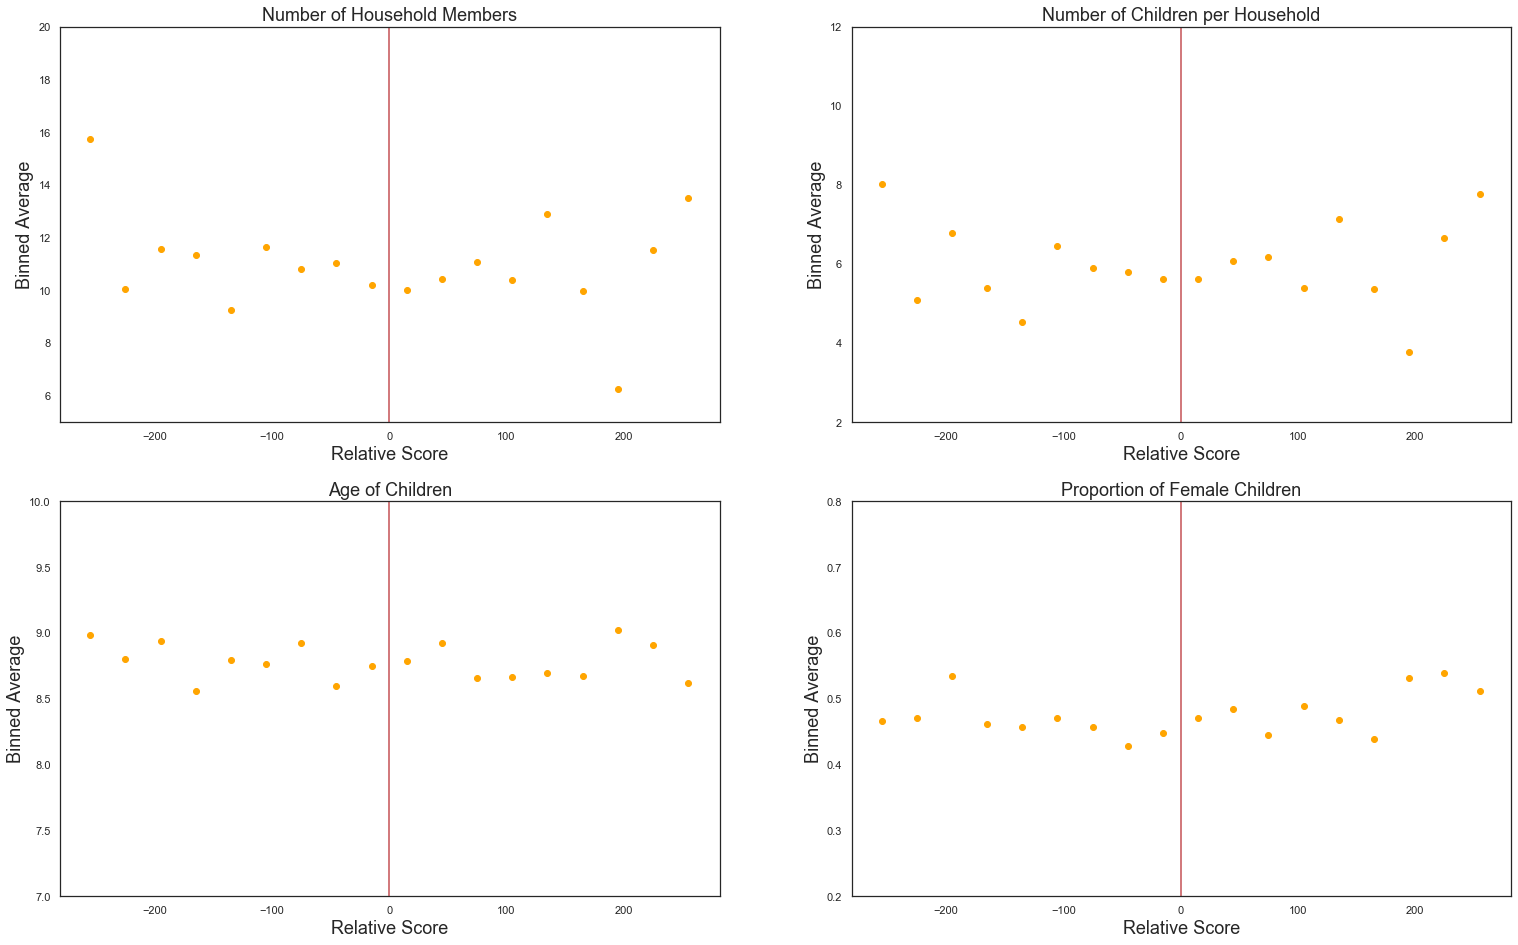

In [59]:
plot_continuity_hh(["Hh_NumMembers","Hh_NumKids","Ch_Age","Ch_Girl"], y_table_2)

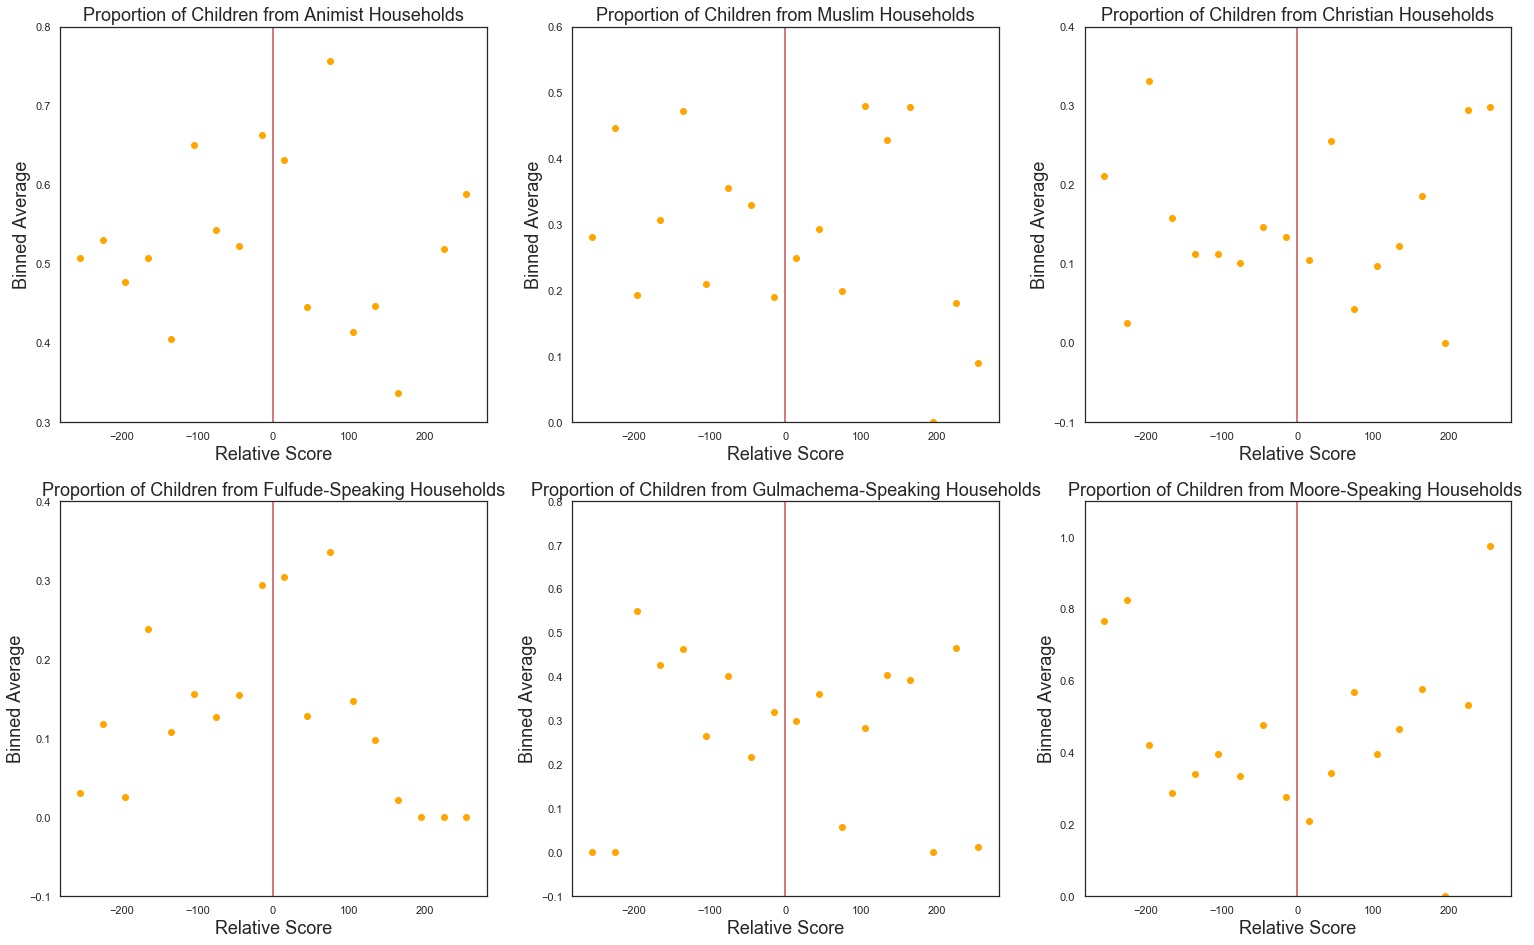

In [60]:
plot_continuity_rel_lang(["Hh_ReligionMuslin","Hh_Animist","Hh_Christian", 
                          "Hh_Lang_Fulfude", "Hh_Lang_Gulmachema", "Hh_Lang_Moore"], y_table_2)

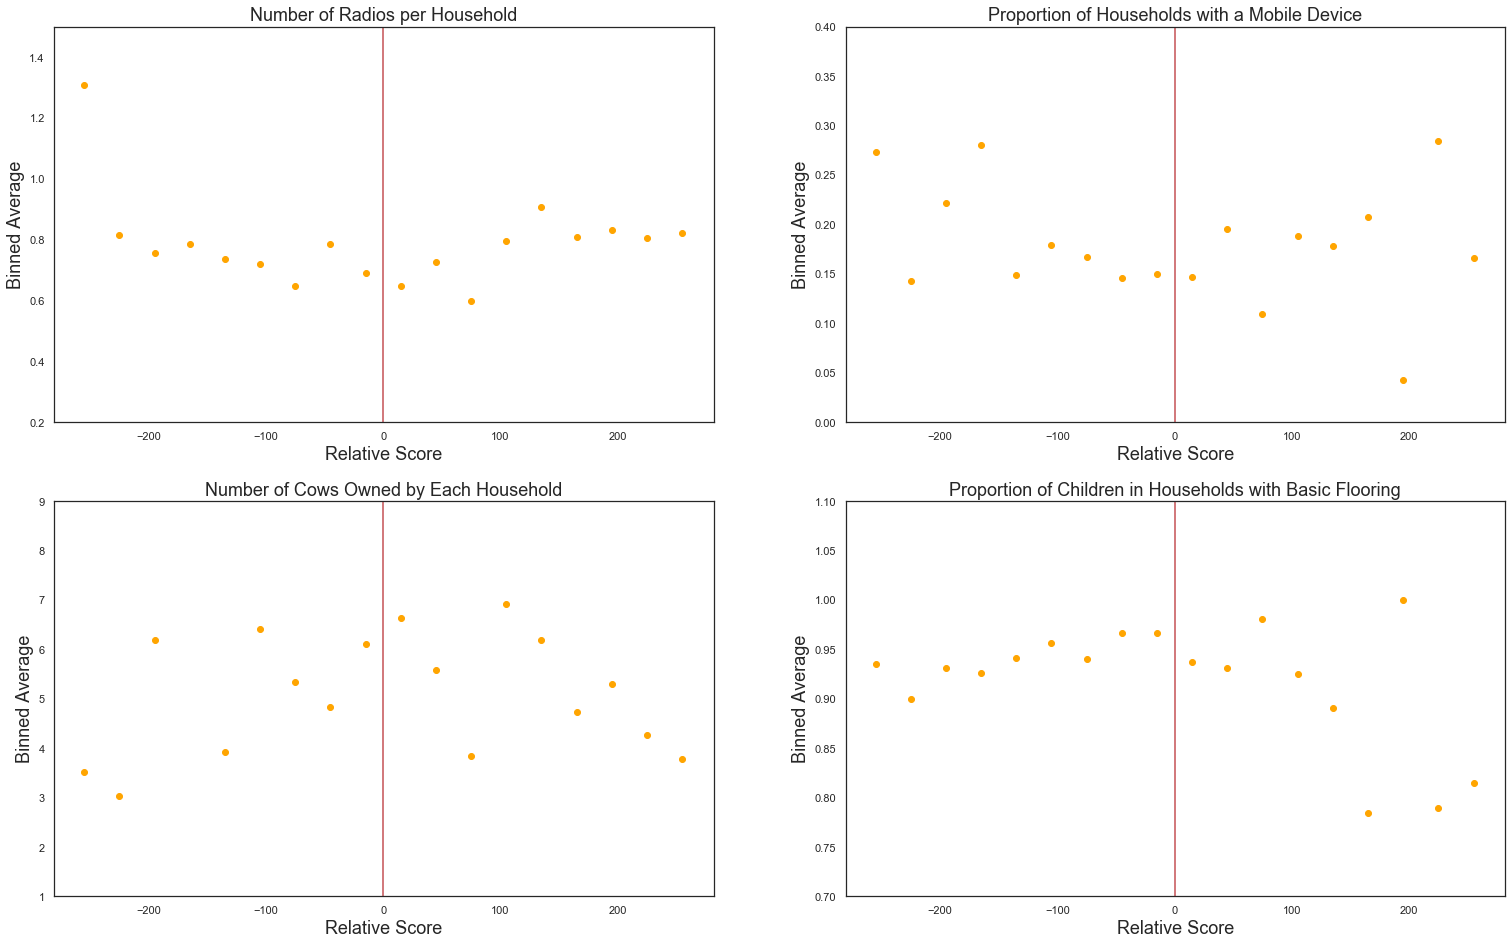

In [61]:
plot_continuity_assets(["Hh_Radio","Hh_Telmob","Hh_Cows","Hh_FloorBasic"], y_table_2)

Due to coding complications that I was unable to resolve, I did not include fitted quadratic regression curves in the continuity subplots. I therefore selected four of the household characteristics depicted in the scatter plots above and created a separate function to do so below. The curves provide a more useful visualization of the estimated continuity for each characteristic. In order to generate fitted curves that are representative of the observations with a relative score between -250 and 250, I introduce a bandwidth of the same size for the regressions plotted below. Doing so does not significantly change the continuity regression results reported in Table 2.  

In [62]:
y_var = ["Hh_NumMembers", "Hh_ReligionMuslin", "Hh_Cows","Hh_FloorBasic", "attending", "total_norm"]
X_matrix = ["proj_selected", "rel_score", "clustercode"]
y_table_quad_reg,X_table_quad_reg = get_data(0,0,0, y_var, X_matrix)
y_table_quad_reg = y_table_quad_reg.loc[abs(X_table_quad_reg["rel_score"]) < 0.0250]
y_table_quad_reg.reset_index(drop = True, inplace = True)
X_table_quad_reg = X_table_quad_reg.loc[abs(X_table_quad_reg["rel_score"]) < 0.0250]
X_table_quad_reg.reset_index(drop = True, inplace = True)


#### Figure E2. Fitted Quadratic Regressions for A Subset of the Above Demographic Characteristics 

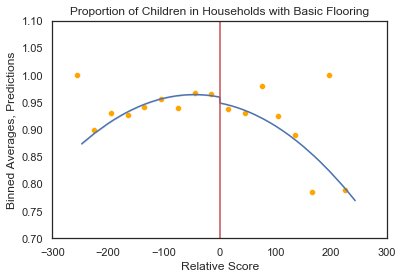

In [63]:
plot_continuity_quad_reg(y_table_quad_reg, X_table_quad_reg,"Hh_FloorBasic","Proportion of Children in Households with Basic Flooring",0.7,1.1)



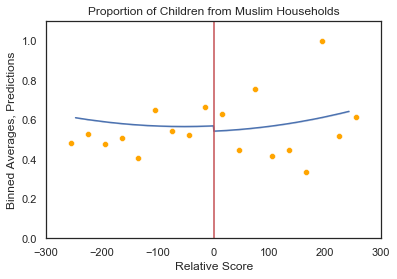

In [64]:
plot_continuity_quad_reg(y_table_quad_reg, X_table_quad_reg,"Hh_ReligionMuslin","Proportion of Children from Muslim Households",0,1.1)


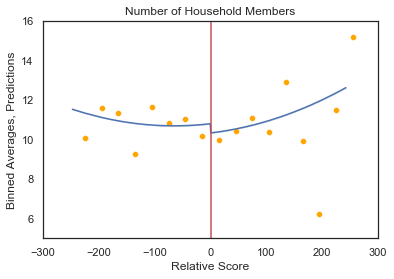

In [65]:
plot_continuity_quad_reg(y_table_quad_reg, X_table_quad_reg,"Hh_NumMembers","Number of Household Members",5,16)


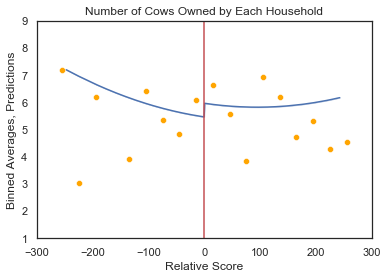

In [66]:
plot_continuity_quad_reg(y_table_quad_reg, X_table_quad_reg,"Hh_Cows","Number of Cows Owned by Each Household",1,9)


## 6.2. Treatment Effect on Normalized Math and French Test Scores Disaggregated by Gender <a name="6.2"></a>

As a further robustness check of the results reported by Kazianza et al. (2013), I look more closely at children's academic performance disaggregated by gender. Aside from the estimated treatment effect on overall normalized test scores reported in Table 7, the authors also evaluate the observed treatment effect of the BRIGHT program on French and math test scores, respectively, in Tables A5 and A6 of their [online Appendix](https://assets.aeaweb.org/asset-server/articles-attachments/aej/app/app/2012-0175_app.pdf). I take the regressions summarized in A5 and A6 a step further by observing if there is a markedly higher improvement in the French and math test results of girls over their male counterparts. According to the estimates summarized in  Table E2 below, the BRIGHT program does not achieve a significantly larger effect on the academic performance of girls compared to boys for either subject. 

In [67]:
y_var_robust_extension = ["lang_norm", "math_norm"]
X_matrix_robust_extension = ["proj_selected", "rel_score", "Ch_GirlXproj", "clustercode"]

y_table_robust_extension,X_table_robust_extension = get_data(0,0,1, y_var_robust_extension, X_matrix_robust_extension)

#### Table E2. The Estimated Treatment Effect on Normalized Math and French Test Scores by Gender 

In [68]:
create_table_E1(y_table_robust_extension,y_var_robust_extension,X_table_robust_extension)

BRIGHT Program (Selected)         Selected x Female        
                        Coefficient P-value       Coefficient P-value
lang_norm                     0.368     0.0             0.012   0.748
math_norm                     0.399     0.0             0.014   0.678

## 6.3. Plotting Parametric Regression Results <a name="6.3"></a>

Although Kazianga et al. (2013) visualize the estimated discontinuities for their nonparametric regressions in Figures 1, 3, and 4, they only publish the estimated regression coefficients in a table format for their parametric regression results. While this procedure is suitable for the authors' objectives, I slightly extend the scope of their paper by using two different regression models to plot the conditional mean functions on either side of the cutoff. I first plot the treatment effect using the joint regression discontinuity model originally specified by Kazianga et al. (2013) in equation (1). I then measure the effect by splitting the data set according to assigned treatment and running two independent regressions for the observations in the selected and nonselected villages, respectively. Plotting the fitted curves of these two model specifications lends further insight into their unique structural forms. 

Analogous to the set up in section 6.1, I restrict the data set to a bandwidth of 250 in order to remain consistent with the authors' graphical formatting in the original paper. As mentioned previously, this modification does not impact the economic or statistical significance of the parametric estimates reported by Kazianga et al. (2013). Additionally, I only control for department fixed effects due to the robustness of the measured treatment effect of the BRIGHT program on attendance and normalized total test scores. To avoid confusion, I address the treatment effect on the two main outcome variables separately. In section 6.3.1, I plot the joint and individual discontinuity regressions for attendance. I then perform the same procedure in section 6.3.2 for total test scores. 

Given the explicit structure of the joint regression, it is clear from Figures E3 and E5 that the slope on either side of the cutoff is the same. Although an advantage of running a joint regression is that one directly obtains an estimate and standard error for the treatment effect in question, restricting the slope to be identical for the control and treatment groups compromises the inherent strength of the RD design (Lee and Lemieux, 2010). In particular, the joint regression uses all observations on either side of the cutoff to compute its predictions. This implies that observations in the control group influence the estimate of the conditional expectation of $Y$ as the limit approaches the cutoff from the treatment side and vice versa. As the RD design seeks to estimate the potential outcome functions as the limits approach the cutoff from their respective sides, constraining the slopes may create a less efficient estimate of the treatment effect. In the case that the functional form is the same for both the control and treatment sides, however, the joint regression may be an appropriate strategy. Lee and Lemieux (2010) alternatively recommend running separate regressions for the observations on either side of the cutoff value in order to individually estimate the slope for each side.

Despite the concerns discussed above, the joint and separate regression models plotted for the effects of the BRIGHT program on school attendance yield similar estimates. The difference between the two estimated effects is marginal. The measurements for test scores, however, appear to differ more between the two regression specifications. As is visible in Figure E5, the joint regression discontinuity estimates a nearly linear slope on both sides of the cutoff. Alternatively, the separate regressions in Figure E6 suggest that the individually estimated slopes on either side of the cutoff are not identical. For this reason, the joint regression may slightly overestimate the treatment effect.     

### 6.3.1 Joint and Separate Regression Discontinuity Plots for the Treatment Effect on Attendance <a name="6.3.1"></a>

#### Figure E3. Joint Regression Discontinuity for School Attendance

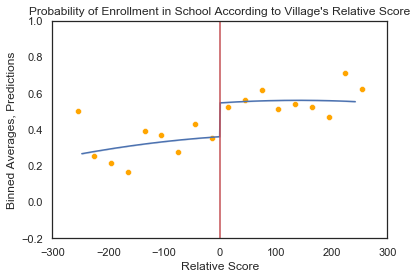

In [69]:
plot_continuity_quad_reg(y_table_quad_reg, X_table_quad_reg,"attending",
                         "Probability of Enrollment in School According to Village's Relative Score",-0.2,1)

In [70]:
quad_attendance_coeff = calculate_polynomial_features(1, y_table_quad_reg["attending"], X_table_quad_reg, 2).params[3]
quad_attendance_pval = calculate_polynomial_features(1, y_table_quad_reg["attending"], X_table_quad_reg, 2).pvalues[3]
print(f'For a bandwidth of 250, the effect of the BRIGHT program on attendance remains robust with a coefficient estimate of {quad_attendance_coeff*100:.4f}% and a statistically significant p-value.')


For a bandwidth of 250, the effect of the BRIGHT program on attendance remains robust with a coefficient estimate of 18.6504% and a statistically significant p-value.


#### Figure E4. School Attendance Regression Discontinuity Measured Using Separate OLS Estimations for Either Side of the Cutoff 

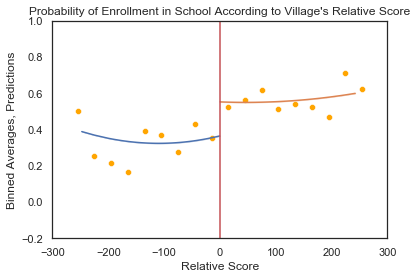

In [71]:
plot_continuity_quad_reg_separated(y_table_quad_reg, X_table_quad_reg, "attending", -0.2, 1, "Probability of Enrollment in School According to Village's Relative Score")

In [72]:
compute_est_effect_separate(y_table_quad_reg, X_table_quad_reg, "attending",1)  


The measured effect on attendance for separately plotted control and treatment regressions is 18.7695%.


### 6.3.2 Joint and Separate Regression Discontinuity Plots for the Treatment Effect on Normalized Total Test Scores <a name="6.3.2"></a>

#### Figure E5. Joint Regression Discontinuity for Test Scores

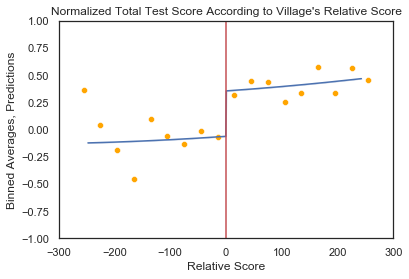

In [73]:
plot_continuity_quad_reg(y_table_quad_reg, X_table_quad_reg,"total_norm",
                         "Normalized Total Test Score According to Village's Relative Score",-1,1)

In [74]:
quad_testing_coeff = calculate_polynomial_features(1, y_table_quad_reg["total_norm"], X_table_quad_reg, 2).params[3]
quad_testing_pval = calculate_polynomial_features(1, y_table_quad_reg["total_norm"], X_table_quad_reg, 2).pvalues[3]
print(f'For a bandwidth of 250, the effect of the BRIGHT program on attendance remains robust with a coefficient estimate of {quad_testing_coeff:.4f} and a statistically significant p-value.')


For a bandwidth of 250, the effect of the BRIGHT program on attendance remains robust with a coefficient estimate of 0.4175 and a statistically significant p-value.


#### Figure E6. Test Score Regression Discontinuity Measured Using Separate OLS Estimations for Either Side of the Cutoff 

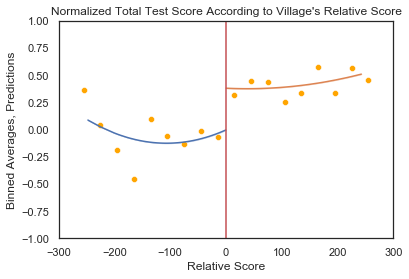

In [75]:
plot_continuity_quad_reg_separated(y_table_quad_reg, X_table_quad_reg, "total_norm", -1, 1,"Normalized Total Test Score According to Village's Relative Score")

In [76]:
compute_est_effect_separate(y_table_quad_reg, X_table_quad_reg,"total_norm",0) 

The measured effect on normalized total test scores for separately plotted control and treatment regressions is 0.3835 standard deviations.


## 6.4. Evaluation of Placebo Thresholds <a name="6.4"></a>

A common tool used to confirm the existence of a threshold discontinuity in RD designs are placebo tests. Among many other methods of application, placebo tests involve selecting an arbitrary value of the running variable that deviates from the true threshold and testing if there exists a measurable effect on the outcome variable. In so doing, we only anticipate an effect at the true cutoff point and no effect at any  placebo cutoff. To carry out this extension, I first subset the observations at the child level according to their treatment assignment. I then create a series of treatment dummies for various placebo cutoffs. For the untreated individuals, I select placebo cutoffs at the following relative score values around the true threshold: -125, -62.5, -31.25, and -15.625. I do the same for the subset of individuals belonging to the treatment group: 15.625, 31.25, 62.5, 125. At each placebo cutoff, I produce a dummy variable such that the individuals, who live in a village with a relative score that falls above the cutoff are selected into the placebo treatment group, while those from a village with a relative score  below the threshold are allocated to the placebo control group. I then run a simple linear OLS regression specified by equation (1), in which I account for department fixed effects. The results for the two principle outcome variables, school attendance and total test scores, are summarized below in Tables E7 through E10.

As expected, the regression results for this basic model specification yield small coefficient estimates on the respective placebo treatment variables that are statistically insignificant. To confirm the robustness of my results, I performed alternative model specifications in which I included the preferred quadratic model used by Kazianga et al. (2013) as well as demographic controls. For the strict regression evaluation, in which I apply a quadratic polynomial expansion as well as demographic controls and department fixed effects, the regression output indicates mild statistical significance at the 10 percent level for the placebo thresholds nearest to the true cutoff value. However, the corresponding confidence intervals remain centered around zero. These further specifications thus generate similar results to the basic case, indicating that there are no measurable effects on the outcome variables at randomly selected cutoffs.

In [77]:
y_var_placebo = ["attending", "total_norm"]
X_matrix_placebo = ["proj_selected", "rel_score", "clustercode"]
y_placebo,X_placebo = get_data(0,0,0, y_var_placebo, X_matrix_placebo)

#The code below includes the preferred quadratic model specification as well as
#fixed effects **and** demographic controls:

#X_matrix_placebo = ["proj_selected", "rel_score", "rel_score2", "clustercode"]
#y_placebo,X_placebo = get_data(0,0,1, y_var_placebo, X_matrix_placebo)


### 6.4.1. Placebo Tests for the Treatment Effect on School Attendance <a name="6.4.1"></a>

#### Table E7. Placebo Threshold Results for School Attendance (Control Side)

In [78]:
LHS_placebo_thresholds_attendance = iterate_placebo_test(y_placebo["attending"], X_placebo, 0)
LHS_placebo_thresholds_attendance

,Placebo Cutoff,Coefficient Estimate,P-value,Conf. Int. Lower,Conf. Int. Upper
Index,,,,,
0,-125.000,0.019949,0.744669,-0.100107,0.140005
1,-62.500,-0.035528,0.375012,-0.114022,0.042966
2,-31.250,-0.014951,0.700693,-0.091186,0.061284
3,-15.625,0.047822,0.242614,-0.032393,0.128036


#### Table E8. Placebo Threshold Results for School Attendance (Treatment Side)

In [79]:
RHS_placebo_thresholds_attendance = iterate_placebo_test(y_placebo["attending"], X_placebo, 1)
RHS_placebo_thresholds_attendance

,Placebo Cutoff,Coefficient Estimate,P-value,Conf. Int. Lower,Conf. Int. Upper
Index,,,,,
0,125.000,0.025478,0.493609,-0.047466,0.098422
1,62.500,0.011074,0.758341,-0.059474,0.081622
2,31.250,0.008750,0.760680,-0.047556,0.065057
3,15.625,-0.023922,0.438972,-0.084504,0.036660


### 6.4.2. Placebo Tests for the Treatment Effect on Total Test Scores <a name="6.4.2"></a>

#### Table E9. Placebo Threshold Results for Total Test Scores (Control Side)

In [80]:
LHS_placebo_thresholds_testing = iterate_placebo_test(y_placebo["total_norm"], X_placebo, 0)
LHS_placebo_thresholds_testing

,Placebo Cutoff,Coefficient Estimate,P-value,Conf. Int. Lower,Conf. Int. Upper
Index,,,,,
0,-125.000,-0.024010,0.858607,-0.288167,0.240147
1,-62.500,-0.059645,0.476069,-0.223684,0.104395
2,-31.250,-0.053977,0.508089,-0.213828,0.105875
3,-15.625,0.060101,0.492586,-0.111562,0.231763


#### Table E10. Placebo Threshold Results for Total Test Scores (Treatment Side)

In [81]:
RHS_placebo_thresholds_testing = iterate_placebo_test(y_placebo["total_norm"], X_placebo, 1)
RHS_placebo_thresholds_testing

,Placebo Cutoff,Coefficient Estimate,P-value,Conf. Int. Lower,Conf. Int. Upper
Index,,,,,
0,125.000,0.051727,0.485815,-0.093733,0.197186
1,62.500,0.006877,0.922398,-0.131479,0.145232
2,31.250,0.032120,0.644695,-0.104398,0.168639
3,15.625,-0.011364,0.877812,-0.156237,0.133509


## 6.5. Bandwidth Sensitivity Checks <a name="6.5"></a>

When alternative parametric and nonparametric strategies generate a suboptimal regression fit, Lee and Lemieux (2010) suggest implementing a local linear regression (LLR), in which a linear regression is run for a  subset of data observations marginally close to the cutoff. Alternatively, if a parametric functional form such as a low-order polynomial expansion produces an appropriate regression fit, exhibiting little to no bias, then running a regression using all observations may be a suitable strategy.

As the authors do not extensitvely perform local linear regressions around the cutoff and instead use all 17,970 observations in their parametric regression analyses, I introduce bandwidth checks to observe whether the results reported by Kazianga et al. (2013) are sensitive to using increasingly smaller subsets of the original data near the cutoff. As the results from the linear model specification remain robust with the removal of demographic controls, I only include department fixed effects for the regressions reported here. In the following section, I perform these checks for changes in the two primary outcome variables, attendance and normalized total test scores, respectively. 

The first analysis evaluates the changes to the estimated local treatment effect and to the corresponding p-value for several bandwidths. As a baseline estimate, the first row of Tables E3 and E5 reports the treatment effect before any bandwidth has been introduced. In this case, the BRIGHT program increases the probably of school attendance for all children by approximately 21.19% and improves test scores by 0.46 standard deviations. For the first seven bandwidths, starting with a fairly large relative score of 400 and decreasing to a score of 125, the estimated treatment effects on attendance remain consistent with the linear regression estimate without a bandwidth, ranging between 17.70% and 20.98%. The respective p-values are also highly statistically significant. As the bandwidths become increasingly smaller, however, the estimated treatment effect begins to exhibit more sensitivity. Although most of the corresponding p-values remain statistically significant at the 5% or 10% levels, they are clearly less significant than the estimates for larger bandwidths.

The observed changes in treatment effect on test scores suggests that the collected data for academic performance is more sensitive to the bandwidth check. For a bandwidth as small as 250, the treatment effect remains between .40 and .48 standard deviations. As the bandwidth decreases to relative score 125, the estimates of the effect fall below .40 standard deviations, but remain higher than 0.36 standard deviations. These estimates, however, maintain a high level of statistical significance. As the bandwidth drops below 125, the estimated treatment effects vary more intensely and begin to lose their statistical significance. Two estimates in particular - for bandwidths of 31.25 and 10 - remain economically significant, but no longer exhibit statistical significance at conventional levels.

As a second bandwidth sensitivity check, I apply the “leave one out” cross-validation procedure, in which the predicted values, $\hat{Y}$, at $X = X_i$ are estimated by excluding the observation $i$ and running a local linear regression. This procedure is performed individually for all observations on either side of the threshold value. Once all predicted values are obtained for the observations within a specified bandwidth, the overall mean square error (MSE) is computed by averaging the squared prediction errors derived on either side of the cutoff. The bandwidth with the lowest MSE is thus large enough to derive a precise estimate, but small enough to yield a sufficiently accurate linear model specification (Lee and Lemieux, 2010). For the treatment effect on attendance and test scores, respectively, the MSEs calculated from the "leave one out" procedure exhibit little variation. The MSEs for the effect on attendance range between 0.211 and 0.201. Likewise, all but one bandwidth yield an MSE between 1.01 and 0.94 for the effect on test scores (for the final bandwidth at relative score 5, the MSE for the test score observations increases to 1.19). As a result, the introduced bandwidths do not significantly improve the MSE.



In [82]:
y_bndwd, X_bndwd = get_data(0,0,0, ["total_norm","attending"], ["rel_score","proj_selected","clustercode"])
y_bndwd_MSE, X_bndwd_MSE = get_data(0,0,0, ["attending","total_norm"], "rel_score")

In [83]:
#bandwidth = [1, 0.0400, 0.0300, 0.0250, 0.01875,0.0125, 0.003125, 0.0015625, 0.0010, 0.0005]

### | Bandwidth Sensitivity for the Treatment Effect on Attendance

#### Table E3. Changes in the Estimated Treatment Effect on Attendance

In [84]:
check_effect_bandwidth(y_bndwd["attending"], X_bndwd, 1)

,"Treatment Effect, %",P-value
Bandwidth,,
10000.000,21.186229,0.000
400.000,20.981540,0.000
300.000,18.203129,0.000
250.000,18.572538,0.000
187.500,19.061769,0.000
125.000,18.975753,0.000
31.250,5.927554,0.360
15.625,13.993984,0.093
10.000,19.517079,0.085


#### Table E4. Results from the “Leave One Out” Cross-Validation Procedure for School Attendance

In [85]:
#create_bandwidth_check(y_bndwd_MSE["attending"], X_bndwd_MSE, bandwidth)
create_bndwd_check_att = {"Bandwidth": [1000,400,300,250,187.5,125,31.25,15.625,10,5],
                      "MSE": [0.21129,0.209526,0.208515,0.208851,0.208996,0.209181,
                              0.200981,0.204528,0.200916,0.205581]}
create_bndwd_check_att_df = pd.DataFrame(create_bndwd_check_att)
create_bndwd_check_att_df.set_index(["Bandwidth"], inplace=True)
create_bndwd_check_att_df

,MSE
Bandwidth,
1000.000,0.211290
400.000,0.209526
300.000,0.208515
250.000,0.208851
187.500,0.208996
125.000,0.209181
31.250,0.200981
15.625,0.204528
10.000,0.200916


### | Bandwidth Sensitivity for the Treatment Effect on Normalized Total Test Scores

#### Table E5. Changes in the Estimated Treatment Effect on Academic Performance

In [86]:
check_effect_bandwidth(y_bndwd["total_norm"], X_bndwd, 0)

,"Treatment Effect, std",P-value
Bandwidth,,
10000.000,0.464463,0.000
400.000,0.475228,0.000
300.000,0.402353,0.000
250.000,0.416954,0.000
187.500,0.363156,0.000
125.000,0.376530,0.000
31.250,0.189655,0.189
15.625,0.302297,0.094
10.000,0.310040,0.206


#### Table E6. Results from the “Leave One Out” Cross-Validation Procedure for Academic Performance

In [87]:
#create_bandwidth_check(y_bndwd_MSE["total_norm"], X_bndwd_MSE, bandwidth)
create_bndwd_check_test = {"Bandwidth": [1000,400,300,250,187.5,125,31.25,15.625,10,5],
                           "MSE": [1.01461,1.005749,1.001082,0.999612,0.988794,0.974925,
                                   0.938921,0.961493,0.982658,1.186763]}
create_bndwd_check_test_df = pd.DataFrame(create_bndwd_check_test)
create_bndwd_check_test_df.set_index(["Bandwidth"], inplace=True)
create_bndwd_check_test_df

,MSE
Bandwidth,
1000.000,1.014610
400.000,1.005749
300.000,1.001082
250.000,0.999612
187.500,0.988794
125.000,0.974925
31.250,0.938921
15.625,0.961493
10.000,0.982658


To better understand the results from both sensitivity checks, it is necessary to take a closer look at the distributions of the demographic characteristics for the whole range of the relative score. In many other research contexts, observations farther away from the threshold may systematically differ from the data points marginally close to the cutoff in one or more of the observed covariates, thus introducing some degree of estimation bias into the measured treatment effect. Performing an LLR with a subset of observations selected by an optimizing bandwidth better ensures that the data points on either side of the cutoff exhibit continuity in the distributions of the covariates and thus may serve as an appropriate alternative to parametric regression. 

As acknowledged in Table 2 of Kazianga et al. (2013) and in the extensions summarized in section 6.1 of this notebook, the control and treatment groups are largely similar across all 28 observed characteristics. Table A1 of the [Online Appendix](https://assets.aeaweb.org/asset-server/articles-attachments/aej/app/app/2012-0175_app.pdf) reports further analyses of the village characteristics by disaggregating the child observations according to how close their villages' relative score is to the cutoff. They conclude that children, whose villages have a relative score marginally close to the cutoff (i.e., villages with a relative score between -40 and 40), are characteristically similar to those living in villages with a score farther away from the cutoff. As the computed average differences for the 28 observed demographic controls are small, it is safe to conclude that the continuity assumption holds for the entire distribution of each demographic characteristic, not just for the observations with relative scores marginally close to the threshold. 

The results from the two bandwidth sensitivity checks seem to confirm this analysis. As the introduced bandwidths do not significantly improve the MSE for either of the measured treatment effects, the balance between precision and bias described above does not significantly improve with the introduction of a bandwidth. Likewise, as the bandwidths become smaller and fewer observations are used in the LLR model, the estimated treatment effects lose much of their statistical significance. Given the features of the data set as well as the results from the bandwidth sensitivity checks, a parametric regression with a low-order polynomial is thus a more appropriate strategy than a nonparametric LLR with an optimized bandwidth.



---

<span style="color:darkred">**NOTE**:</span> Due to a degree of computational intensity for the "leave one out" procedure that my computer cannot seem to handle, I calculated the MSE for each bandwidth individually using the `create_bandwidth_check()` function and created Tables E4 and E6 manually. 

---

---
# 7. Concluding Remarks <a name="7"></a>
---

In the above project report, I introduced the basic properties of the RD design and its strengths as an identification strategy. I also replicated the main findings reported in Kazianga et al. (2013) and provided further insights through a number of project extensions described in section 6 of this notebook. My replication results and robustness extensions both corroborate the results published by the authors in the original journal article. 

After only 2.5 years, the BRIGHT program significantly improved enrollment and test scores among all children. For example, BRIGHT increased enrollment by 19 percentage points and exam scores by 0.41 standard deviations for all primary school-age children. The program also increased school enrollment among girls by 5 percentage points more than their male counterparts. Despite this increase in the enrollment rate for girls, Kazianga et al. (2013) do not identify a differential impact on test scores based on gender. That is, the authors observe a comparable increase in test scores for both boys and girls. Furthermore, the individual effects of the BRIGHT program's characteristics are - from an economic as well as a statistical perspective - significantly larger than the education outcomes for children who attend a traditional school. The girl-friendly amenities of the BRIGHT program improve enrollment by 13 percentage points and test scores by 0.35 standard deviations above the effects observed by providing a regular school, indicating that school infrastructure plays an important role in a family's decision to seek education services for their children.

Additionally, the robustness extensions described in section 6.1 lend further evidence to support the critical continuity assumption. The robustness check in 6.2 shows that the lack of a differential impact on total test scores between boys and girls holds true when academic performance is measured separately for math and French. In sections 6.3 and 6.4, respectively, the parametric regression plots and the placebo tests corroborate the size as well as the location of the treatment discontinuity for the two main outcome variables. Finally, the bandwidth sensitivity checks in section 6.5 justify the authors' preferred use of a quadratic regression model as opposed to a nonparametric LLR.




---
# 8. Bibliography <a name="8"></a>
---

* **Card, D., Mas, A., & Rothstein, J. (2008)**. Tipping and the Dynamics of Segregation. *Quarterly Journal of Economics*, 123(1), 177–218.

* **Cunningham, S. (2021)**. *Causal Inference: The Mixtape*. New Haven: Yale University Press.

* **Kazianga, H., Levy, D., Linden, L. L., & Sloan, M. (2013)**. The Effects of “Girl-Friendly” Schools: Evidence from the BRIGHT School Construction Program in Burkina Faso. *American Economic Journal: Applied Economics*, 5(3), 41-62.

* **Lee, D. S., & Lemieux, T. (2010)**. Regression Discontinuity Designs in Economics. *Journal of Economic Literature*, 48(2), 281-355.

* **Levy, D., Sloan, M., Linden, L., & Kazianga, H. (2009a)**. Impact Evaluation of Burkina Faso’s Bright Program: Final Report. *Mathematica Policy Research*. Washington, DC, June.

* **McCrary, J. (2008)**. Manipulation of the Running Variable in the Regression Discontinuity Design: A Density Test. *Journal of Econometrics*, 142(2), 698–714.

* **Thistlethwaite, D. L., & Campbell, D. T. (1960)**. Regression-discontinuity analysis: An alternative to the ex post facto experiment. *Journal of Educational Psychology*, 51(6), 309.